# Predicting Dengue Fever Cases using weather data via Catboost Algorithm

### Introduction

This project aims to tackle the Dengue Fever Challenge posted on Driven Data.
Five steps are included in this markdown:
1. importing packages and reading data from source
2. conducting basic EDA (Exploration Data Analysis)
3. feature engineering
4. train a model and test result simply using training data
5. train the model again using all training data and do prediction for the 'submit' set

### Step 1: importing packages and reading data from source 

In [7]:
# import packages
import pandas as pd
import numpy as np
import os 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from catboost import CatBoostRegressor

In [8]:
# reading data
path = os.getcwd() + "/Data/"

data = {}
for file in os.listdir(path):
    data[re.sub(".csv", "", file)] = pd.read_csv(path + file)

training_X = data.pop("DengAI_Predicting_Disease_Spread_-_Training_Data_Features")
training_Y = data.pop("DengAI_Predicting_Disease_Spread_-_Training_Data_Labels")
submit_X = data.pop("DengAI_Predicting_Disease_Spread_-_Test_Data_Features")
submit_Y = data.pop("DengAI_Predicting_Disease_Spread_-_Submission_Format")

# joining data for train_test_split in the later stage
training = training_X.merge(training_Y, on=['city', 'year', 'weekofyear'], how='left')
submit = submit_X.merge(submit_Y, on=['city', 'year', 'weekofyear'], how='left')

### Step 2: conduct basic EDA (Exploratory Data Analysis)

In [9]:
# check the shape of training data
training.shape

(1456, 25)

In [10]:
# check the shape of submission data
submit.shape

(416, 25)

In [11]:
# take a look at the training data
training.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [12]:
# take a look at the submission data
submit.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,0
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,0
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,0
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,0


In [13]:
# check datatypes of each column
training.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [14]:
# check summary of the training data
training.describe(include='all')

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456,1456.000000,1456.000000,1456,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,...,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000
unique,2,NaN,NaN,1049,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,sj,NaN,NaN,2003-07-23,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,936,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2001.031593,26.503434,NaN,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,...,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137
std,NaN,5.408314,15.019437,NaN,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,...,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000
min,NaN,1990.000000,1.000000,NaN,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,NaN,1997.000000,13.750000,NaN,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,...,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,NaN,2002.000000,26.500000,NaN,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,...,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,NaN,2005.000000,39.250000,NaN,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,...,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000


In [15]:
# check summary of the submission data
submit.describe(include='all')

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,416,416.000000,416.000000,416,373.000000,405.000000,415.000000,415.000000,414.000000,414.000000,...,414.000000,414.000000,414.000000,414.000000,404.000000,404.000000,413.000000,407.000000,411.000000,416.0
unique,2,NaN,NaN,269,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,sj,NaN,NaN,2011-07-23,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,260,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2010.766827,26.439904,NaN,0.126050,0.126803,0.207702,0.201721,38.354324,298.818295,...,82.499810,38.354324,16.927088,5.124569,27.369587,7.810991,32.534625,22.368550,34.278589,0.0
std,NaN,1.434835,14.978257,NaN,0.164353,0.141420,0.079102,0.092028,35.171126,1.469501,...,7.378243,35.171126,1.557868,3.542870,1.232608,2.449718,1.920429,1.731437,34.655966,0.0
min,NaN,2008.000000,1.000000,NaN,-0.463400,-0.211800,0.006200,-0.014671,0.000000,294.554286,...,64.920000,0.000000,12.537143,1.485714,24.157143,4.042857,27.200000,14.200000,0.000000,0.0
25%,NaN,2010.000000,13.750000,NaN,-0.001500,0.015975,0.148670,0.134079,8.175000,297.751429,...,77.397143,8.175000,15.792857,2.446429,26.514286,5.928571,31.100000,21.200000,9.100000,0.0
50%,NaN,2011.000000,26.000000,NaN,0.110100,0.088700,0.204171,0.186471,31.455000,298.547143,...,80.330000,31.455000,17.337143,2.914286,27.483333,6.642857,32.800000,22.200000,23.600000,0.0
75%,NaN,2012.000000,39.000000,NaN,0.263329,0.242400,0.254871,0.253243,57.772500,300.240357,...,88.328929,57.772500,18.174643,8.171429,28.319048,9.812500,33.900000,23.300000,47.750000,0.0


In [16]:
# Check if there is any NA in training data
training.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [17]:
# Check if there is any NA in submission data
submit.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

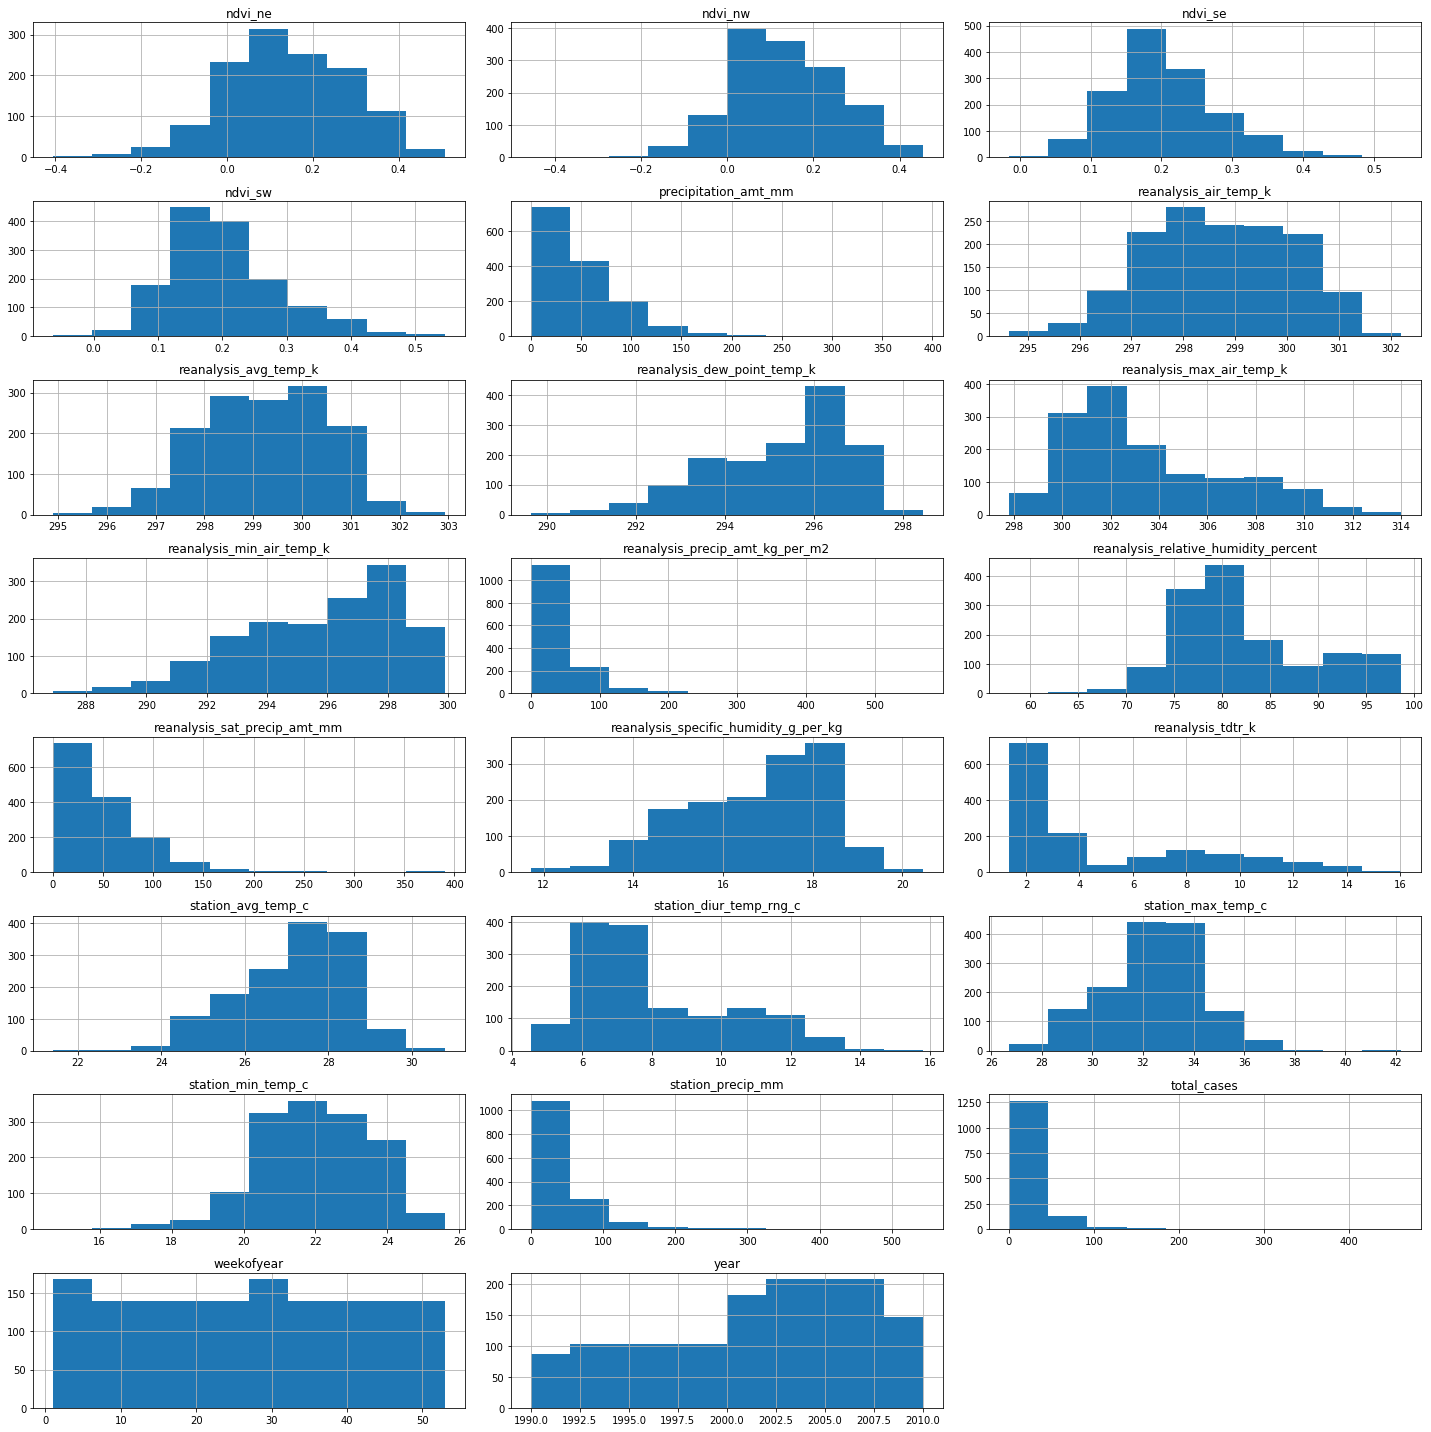

In [18]:
# Observe histogram of each numeric feature
plt.figure()
training.hist(figsize=(20,20), layout=(8,3))
plt.tight_layout()
plt.show()

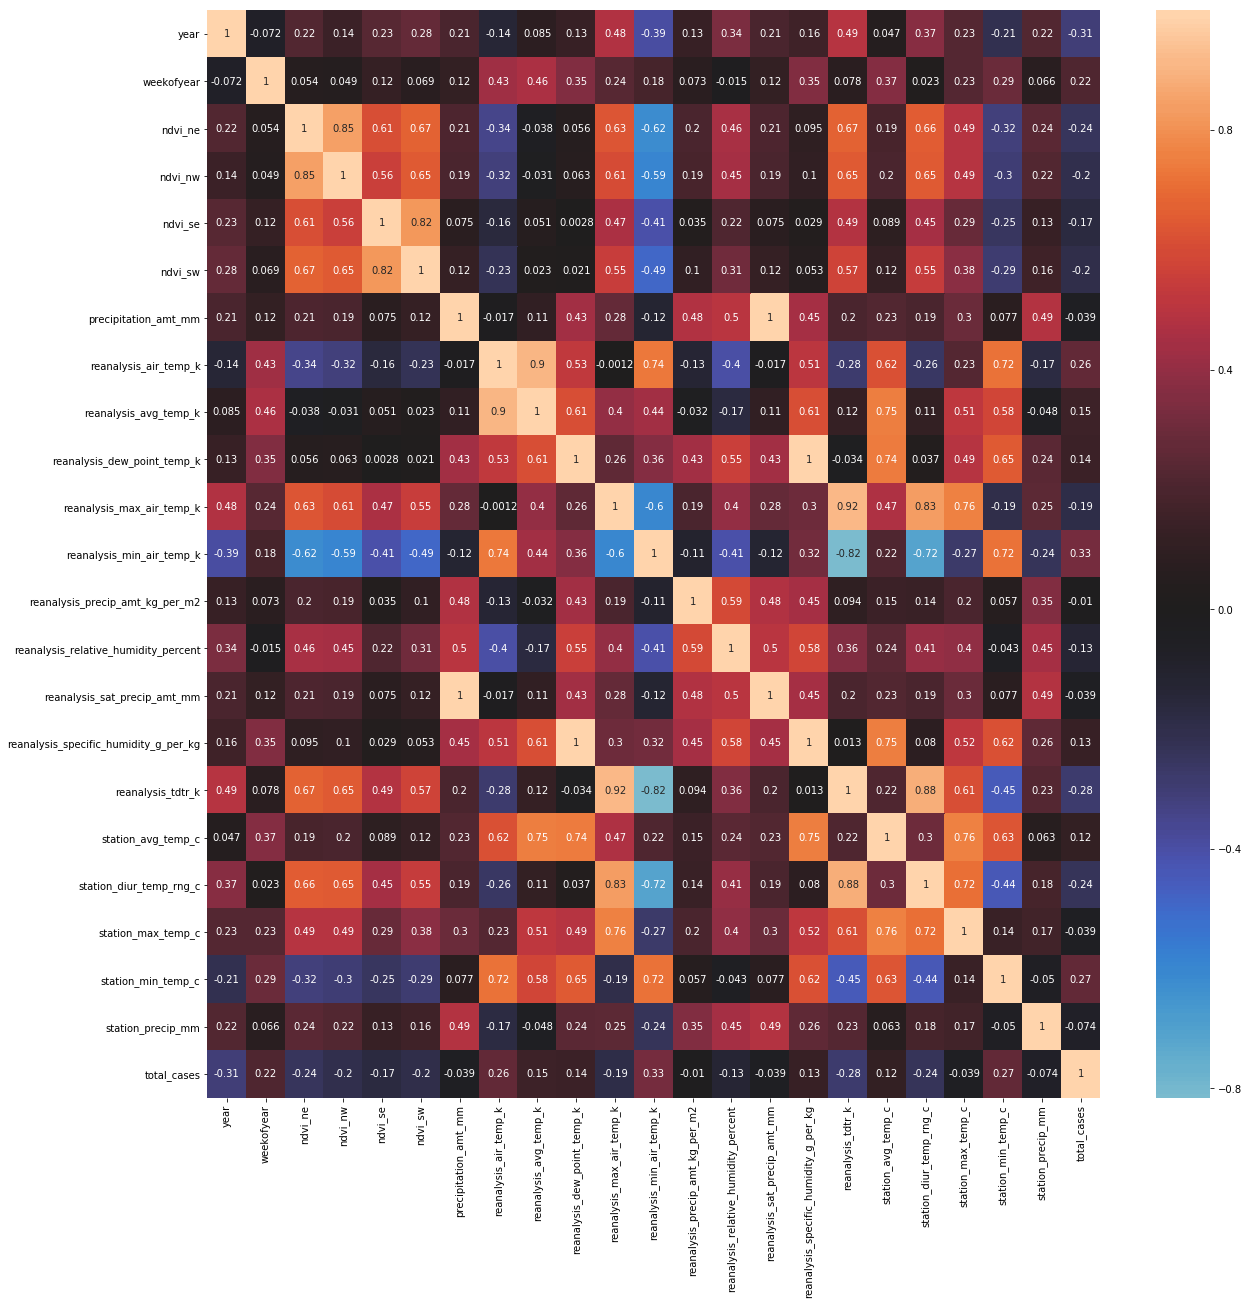

In [19]:
# Explore correlation between variables
plt.figure(figsize=(20,20))
sns.heatmap(training.corr(), xticklabels=training.corr().columns, yticklabels=training.corr().columns, center=0, annot=True)
plt.show()

### Step 3: feature engineering

Based on the exploratory data analysis, it seems that the following steps could/should be done:
1. generating datetime features
2. filling NAs
3. removing highly correlated features
4. one-hot encoding for categorical features

For step 2, since the NA values for each column are weather related data, it makes sense to fillna in groups of city and month.
And as the NA values only accounts for less than 10% of the total data for each column, a naive method, median would be used.

In [20]:
# generating date_time features
training['week_start_date'] = pd.to_datetime(training['week_start_date'], format='%Y-%m-%d')
training['quarter'] = training.week_start_date.dt.quarter
training['month'] = training.week_start_date.dt.month
training['day'] = training.week_start_date.dt.day

submit['week_start_date'] = pd.to_datetime(submit['week_start_date'], format='%Y-%m-%d')
submit['quarter'] = submit.week_start_date.dt.quarter
submit['month'] = submit.week_start_date.dt.month
submit['day'] = submit.week_start_date.dt.day

In [21]:
# fillna via naive method, median, grouped by city and month
training = training.groupby(['city', 'month'], as_index=False).apply(lambda x: x.fillna(x.median())).reset_index(drop=True)
submit = submit.groupby(['city', 'month'], as_index=False).apply(lambda x: x.fillna(x.median())).reset_index(drop=True)

In [22]:
# Remove some highly correlated non-datetime related features (absolute correlation > 0.9)
features_to_remove = ['reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_avg_temp_k', 'reanalysis_tdtr_k']
training.drop(features_to_remove, axis=1, inplace=True)
submit.drop(features_to_remove, axis=1, inplace=True)

In [23]:
# one-hot encoding for categorical data: city
training = pd.concat([pd.get_dummies(training.city).astype(int), training], axis=1)
submit = pd.concat([pd.get_dummies(submit.city).astype(int), submit], axis=1)

### Step 4: train a model and test result simply using training data

This step helps us understand the accuracy of our model before using it to predict the 'submit' dataset

In [24]:
# drop week_start_date before training
training.drop(['week_start_date'], axis=1, inplace=True)
submit.drop(['week_start_date'], axis=1, inplace=True)

In [25]:
# train test split for train, test and cv and then drop categorical variable: city
X_train, X_test, y_train, y_test = train_test_split(training.drop(['total_cases'], axis=1), training.total_cases, test_size=0.2, stratify=training.city, random_state=123)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, stratify=X_train.city, random_state=123)

X_train.drop('city', axis=1, inplace=True)
X_cv.drop('city', axis=1, inplace=True)
X_test.drop('city', axis=1, inplace=True)

In [26]:
# train the model
model = CatBoostRegressor(iterations = 4000, learning_rate = 0.3, loss_function='MAE', eval_metric='MAE', use_best_model=True, random_seed=123)
model.fit(X_train, y_train, eval_set=(X_cv, y_cv), verbose=1)

0:	learn: 24.6619113	test: 21.8641054	best: 21.8641054 (0)	total: 79.4ms	remaining: 5m 17s
1:	learn: 24.5425861	test: 21.7437191	best: 21.7437191 (1)	total: 108ms	remaining: 3m 36s
2:	learn: 24.4293375	test: 21.6288173	best: 21.6288173 (2)	total: 136ms	remaining: 3m 1s
3:	learn: 24.3207233	test: 21.5181544	best: 21.5181544 (3)	total: 165ms	remaining: 2m 44s
4:	learn: 24.2077914	test: 21.4016279	best: 21.4016279 (4)	total: 184ms	remaining: 2m 27s
5:	learn: 24.1002789	test: 21.2923822	best: 21.2923822 (5)	total: 216ms	remaining: 2m 23s
6:	learn: 23.9919965	test: 21.1836038	best: 21.1836038 (6)	total: 244ms	remaining: 2m 19s
7:	learn: 23.8914076	test: 21.0845934	best: 21.0845934 (7)	total: 274ms	remaining: 2m 16s
8:	learn: 23.7742649	test: 20.9702220	best: 20.9702220 (8)	total: 309ms	remaining: 2m 16s
9:	learn: 23.6773737	test: 20.8759363	best: 20.8759363 (9)	total: 350ms	remaining: 2m 19s
10:	learn: 23.5643492	test: 20.7703917	best: 20.7703917 (10)	total: 393ms	remaining: 2m 22s
11:	lear

90:	learn: 18.4903937	test: 16.3269341	best: 16.3269341 (90)	total: 3.77s	remaining: 2m 42s
91:	learn: 18.4510576	test: 16.2911433	best: 16.2911433 (91)	total: 3.81s	remaining: 2m 42s
92:	learn: 18.4097419	test: 16.2521330	best: 16.2521330 (92)	total: 3.86s	remaining: 2m 42s
93:	learn: 18.3718731	test: 16.2203392	best: 16.2203392 (93)	total: 3.89s	remaining: 2m 41s
94:	learn: 18.3244292	test: 16.1773656	best: 16.1773656 (94)	total: 3.92s	remaining: 2m 41s
95:	learn: 18.2826362	test: 16.1386670	best: 16.1386670 (95)	total: 3.96s	remaining: 2m 41s
96:	learn: 18.2323329	test: 16.0879348	best: 16.0879348 (96)	total: 4s	remaining: 2m 41s
97:	learn: 18.1957038	test: 16.0600652	best: 16.0600652 (97)	total: 4.04s	remaining: 2m 40s
98:	learn: 18.1501738	test: 16.0176395	best: 16.0176395 (98)	total: 4.07s	remaining: 2m 40s
99:	learn: 18.1165727	test: 15.9941483	best: 15.9941483 (99)	total: 4.1s	remaining: 2m 39s
100:	learn: 18.0740836	test: 15.9597122	best: 15.9597122 (100)	total: 4.13s	remainin

183:	learn: 15.7718340	test: 14.1259002	best: 14.1259002 (183)	total: 7.24s	remaining: 2m 30s
184:	learn: 15.7561469	test: 14.1171351	best: 14.1171351 (184)	total: 7.28s	remaining: 2m 30s
185:	learn: 15.7356355	test: 14.1016834	best: 14.1016834 (185)	total: 7.31s	remaining: 2m 29s
186:	learn: 15.7087330	test: 14.0801837	best: 14.0801837 (186)	total: 7.35s	remaining: 2m 29s
187:	learn: 15.6822317	test: 14.0623615	best: 14.0623615 (187)	total: 7.38s	remaining: 2m 29s
188:	learn: 15.6625663	test: 14.0540055	best: 14.0540055 (188)	total: 7.42s	remaining: 2m 29s
189:	learn: 15.6411345	test: 14.0351007	best: 14.0351007 (189)	total: 7.45s	remaining: 2m 29s
190:	learn: 15.6255730	test: 14.0250683	best: 14.0250683 (190)	total: 7.49s	remaining: 2m 29s
191:	learn: 15.6028705	test: 14.0058744	best: 14.0058744 (191)	total: 7.53s	remaining: 2m 29s
192:	learn: 15.5803207	test: 13.9868708	best: 13.9868708 (192)	total: 7.56s	remaining: 2m 29s
193:	learn: 15.5608578	test: 13.9716314	best: 13.9716314 (19

271:	learn: 14.4193941	test: 13.1754061	best: 13.1754061 (271)	total: 9.86s	remaining: 2m 15s
272:	learn: 14.4081447	test: 13.1681395	best: 13.1681395 (272)	total: 9.89s	remaining: 2m 15s
273:	learn: 14.3993350	test: 13.1665942	best: 13.1665942 (273)	total: 9.92s	remaining: 2m 14s
274:	learn: 14.3925528	test: 13.1635906	best: 13.1635906 (274)	total: 9.95s	remaining: 2m 14s
275:	learn: 14.3823693	test: 13.1585874	best: 13.1585874 (275)	total: 9.98s	remaining: 2m 14s
276:	learn: 14.3736676	test: 13.1547053	best: 13.1547053 (276)	total: 10.1s	remaining: 2m 15s
277:	learn: 14.3660674	test: 13.1495072	best: 13.1495072 (277)	total: 10.1s	remaining: 2m 15s
278:	learn: 14.3611895	test: 13.1474971	best: 13.1474971 (278)	total: 10.2s	remaining: 2m 15s
279:	learn: 14.3485758	test: 13.1356053	best: 13.1356053 (279)	total: 10.2s	remaining: 2m 15s
280:	learn: 14.3366058	test: 13.1291471	best: 13.1291471 (280)	total: 10.2s	remaining: 2m 15s
281:	learn: 14.3302272	test: 13.1260694	best: 13.1260694 (28

365:	learn: 13.7071941	test: 12.7568205	best: 12.7568205 (365)	total: 12.9s	remaining: 2m 8s
366:	learn: 13.6968330	test: 12.7529087	best: 12.7529087 (366)	total: 13s	remaining: 2m 8s
367:	learn: 13.6859879	test: 12.7451367	best: 12.7451367 (367)	total: 13s	remaining: 2m 8s
368:	learn: 13.6788667	test: 12.7394276	best: 12.7394276 (368)	total: 13s	remaining: 2m 8s
369:	learn: 13.6701993	test: 12.7339785	best: 12.7339785 (369)	total: 13.1s	remaining: 2m 8s
370:	learn: 13.6630572	test: 12.7324113	best: 12.7324113 (370)	total: 13.1s	remaining: 2m 8s
371:	learn: 13.6540289	test: 12.7273085	best: 12.7273085 (371)	total: 13.1s	remaining: 2m 7s
372:	learn: 13.6441423	test: 12.7214037	best: 12.7214037 (372)	total: 13.1s	remaining: 2m 7s
373:	learn: 13.6391203	test: 12.7185050	best: 12.7185050 (373)	total: 13.2s	remaining: 2m 7s
374:	learn: 13.6332143	test: 12.7144370	best: 12.7144370 (374)	total: 13.2s	remaining: 2m 7s
375:	learn: 13.6268426	test: 12.7118050	best: 12.7118050 (375)	total: 13.2s	

460:	learn: 13.1815394	test: 12.4910985	best: 12.4909802 (459)	total: 15.7s	remaining: 2m
461:	learn: 13.1755936	test: 12.4863975	best: 12.4863975 (461)	total: 15.7s	remaining: 2m
462:	learn: 13.1684774	test: 12.4865311	best: 12.4863975 (461)	total: 15.8s	remaining: 2m
463:	learn: 13.1609747	test: 12.4838717	best: 12.4838717 (463)	total: 15.8s	remaining: 2m
464:	learn: 13.1532360	test: 12.4787177	best: 12.4787177 (464)	total: 15.8s	remaining: 2m
465:	learn: 13.1449622	test: 12.4750101	best: 12.4750101 (465)	total: 15.9s	remaining: 2m
466:	learn: 13.1420173	test: 12.4743209	best: 12.4743209 (466)	total: 15.9s	remaining: 2m
467:	learn: 13.1365970	test: 12.4713882	best: 12.4713882 (467)	total: 15.9s	remaining: 2m
468:	learn: 13.1295430	test: 12.4667003	best: 12.4667003 (468)	total: 15.9s	remaining: 2m
469:	learn: 13.1279932	test: 12.4674979	best: 12.4667003 (468)	total: 16s	remaining: 1m 59s
470:	learn: 13.1264234	test: 12.4668543	best: 12.4667003 (468)	total: 16s	remaining: 1m 59s
471:	l

549:	learn: 12.7612603	test: 12.3205561	best: 12.3205561 (549)	total: 18.3s	remaining: 1m 54s
550:	learn: 12.7573343	test: 12.3198205	best: 12.3198205 (550)	total: 18.3s	remaining: 1m 54s
551:	learn: 12.7543470	test: 12.3194763	best: 12.3194763 (551)	total: 18.4s	remaining: 1m 54s
552:	learn: 12.7515295	test: 12.3186144	best: 12.3186144 (552)	total: 18.4s	remaining: 1m 54s
553:	learn: 12.7450496	test: 12.3177769	best: 12.3177769 (553)	total: 18.4s	remaining: 1m 54s
554:	learn: 12.7412845	test: 12.3151895	best: 12.3151895 (554)	total: 18.4s	remaining: 1m 54s
555:	learn: 12.7344517	test: 12.3111843	best: 12.3111843 (555)	total: 18.5s	remaining: 1m 54s
556:	learn: 12.7272322	test: 12.3103121	best: 12.3103121 (556)	total: 18.5s	remaining: 1m 54s
557:	learn: 12.7176659	test: 12.3035681	best: 12.3035681 (557)	total: 18.5s	remaining: 1m 54s
558:	learn: 12.7137679	test: 12.3019371	best: 12.3019371 (558)	total: 18.6s	remaining: 1m 54s
559:	learn: 12.7130475	test: 12.3016828	best: 12.3016828 (55

642:	learn: 12.3650114	test: 12.1683530	best: 12.1679173 (641)	total: 21.1s	remaining: 1m 50s
643:	learn: 12.3621951	test: 12.1678284	best: 12.1678284 (643)	total: 21.2s	remaining: 1m 50s
644:	learn: 12.3536712	test: 12.1654755	best: 12.1654755 (644)	total: 21.2s	remaining: 1m 50s
645:	learn: 12.3522189	test: 12.1639529	best: 12.1639529 (645)	total: 21.2s	remaining: 1m 50s
646:	learn: 12.3441858	test: 12.1623309	best: 12.1623309 (646)	total: 21.3s	remaining: 1m 50s
647:	learn: 12.3422742	test: 12.1611014	best: 12.1611014 (647)	total: 21.3s	remaining: 1m 50s
648:	learn: 12.3402776	test: 12.1603937	best: 12.1603937 (648)	total: 21.3s	remaining: 1m 50s
649:	learn: 12.3328390	test: 12.1573098	best: 12.1573098 (649)	total: 21.3s	remaining: 1m 49s
650:	learn: 12.3296682	test: 12.1575146	best: 12.1573098 (649)	total: 21.4s	remaining: 1m 49s
651:	learn: 12.3276899	test: 12.1569855	best: 12.1569855 (651)	total: 21.4s	remaining: 1m 49s
652:	learn: 12.3267200	test: 12.1565029	best: 12.1565029 (65

735:	learn: 12.0215257	test: 12.0551314	best: 12.0531514 (727)	total: 24s	remaining: 1m 46s
736:	learn: 12.0178055	test: 12.0562832	best: 12.0531514 (727)	total: 24s	remaining: 1m 46s
737:	learn: 12.0143752	test: 12.0556904	best: 12.0531514 (727)	total: 24s	remaining: 1m 46s
738:	learn: 12.0076426	test: 12.0534234	best: 12.0531514 (727)	total: 24.1s	remaining: 1m 46s
739:	learn: 12.0058746	test: 12.0517762	best: 12.0517762 (739)	total: 24.1s	remaining: 1m 46s
740:	learn: 12.0038393	test: 12.0513194	best: 12.0513194 (740)	total: 24.1s	remaining: 1m 46s
741:	learn: 12.0011709	test: 12.0499876	best: 12.0499876 (741)	total: 24.1s	remaining: 1m 46s
742:	learn: 11.9996252	test: 12.0495011	best: 12.0495011 (742)	total: 24.2s	remaining: 1m 45s
743:	learn: 11.9976783	test: 12.0475226	best: 12.0475226 (743)	total: 24.2s	remaining: 1m 45s
744:	learn: 11.9915856	test: 12.0456721	best: 12.0456721 (744)	total: 24.2s	remaining: 1m 45s
745:	learn: 11.9898749	test: 12.0453565	best: 12.0453565 (745)	tot

826:	learn: 11.7458662	test: 11.9757672	best: 11.9722945 (821)	total: 26.6s	remaining: 1m 41s
827:	learn: 11.7435967	test: 11.9741081	best: 11.9722945 (821)	total: 26.6s	remaining: 1m 41s
828:	learn: 11.7404805	test: 11.9741083	best: 11.9722945 (821)	total: 26.6s	remaining: 1m 41s
829:	learn: 11.7367089	test: 11.9746269	best: 11.9722945 (821)	total: 26.7s	remaining: 1m 41s
830:	learn: 11.7344507	test: 11.9737039	best: 11.9722945 (821)	total: 26.7s	remaining: 1m 41s
831:	learn: 11.7336288	test: 11.9748778	best: 11.9722945 (821)	total: 26.7s	remaining: 1m 41s
832:	learn: 11.7309778	test: 11.9775476	best: 11.9722945 (821)	total: 26.8s	remaining: 1m 41s
833:	learn: 11.7279080	test: 11.9775416	best: 11.9722945 (821)	total: 26.8s	remaining: 1m 41s
834:	learn: 11.7262271	test: 11.9770281	best: 11.9722945 (821)	total: 26.8s	remaining: 1m 41s
835:	learn: 11.7240287	test: 11.9771694	best: 11.9722945 (821)	total: 26.8s	remaining: 1m 41s
836:	learn: 11.7184837	test: 11.9771599	best: 11.9722945 (82

920:	learn: 11.5036534	test: 11.9463696	best: 11.9459266 (911)	total: 29.2s	remaining: 1m 37s
921:	learn: 11.5015450	test: 11.9450780	best: 11.9450780 (921)	total: 29.2s	remaining: 1m 37s
922:	learn: 11.4951044	test: 11.9433745	best: 11.9433745 (922)	total: 29.3s	remaining: 1m 37s
923:	learn: 11.4941039	test: 11.9433037	best: 11.9433037 (923)	total: 29.3s	remaining: 1m 37s
924:	learn: 11.4911993	test: 11.9429212	best: 11.9429212 (924)	total: 29.3s	remaining: 1m 37s
925:	learn: 11.4901289	test: 11.9429993	best: 11.9429212 (924)	total: 29.3s	remaining: 1m 37s
926:	learn: 11.4848364	test: 11.9409901	best: 11.9409901 (926)	total: 29.4s	remaining: 1m 37s
927:	learn: 11.4820079	test: 11.9390677	best: 11.9390677 (927)	total: 29.4s	remaining: 1m 37s
928:	learn: 11.4805838	test: 11.9387507	best: 11.9387507 (928)	total: 29.4s	remaining: 1m 37s
929:	learn: 11.4782243	test: 11.9399198	best: 11.9387507 (928)	total: 29.4s	remaining: 1m 37s
930:	learn: 11.4758173	test: 11.9402009	best: 11.9387507 (92

1012:	learn: 11.2493717	test: 11.8770563	best: 11.8744628 (1010)	total: 31.8s	remaining: 1m 33s
1013:	learn: 11.2455104	test: 11.8761592	best: 11.8744628 (1010)	total: 31.8s	remaining: 1m 33s
1014:	learn: 11.2423148	test: 11.8761510	best: 11.8744628 (1010)	total: 31.9s	remaining: 1m 33s
1015:	learn: 11.2401975	test: 11.8755096	best: 11.8744628 (1010)	total: 31.9s	remaining: 1m 33s
1016:	learn: 11.2382259	test: 11.8761737	best: 11.8744628 (1010)	total: 31.9s	remaining: 1m 33s
1017:	learn: 11.2336220	test: 11.8731350	best: 11.8731350 (1017)	total: 31.9s	remaining: 1m 33s
1018:	learn: 11.2314135	test: 11.8725847	best: 11.8725847 (1018)	total: 32s	remaining: 1m 33s
1019:	learn: 11.2255234	test: 11.8711355	best: 11.8711355 (1019)	total: 32s	remaining: 1m 33s
1020:	learn: 11.2225796	test: 11.8716537	best: 11.8711355 (1019)	total: 32s	remaining: 1m 33s
1021:	learn: 11.2204974	test: 11.8714803	best: 11.8711355 (1019)	total: 32.1s	remaining: 1m 33s
1022:	learn: 11.2183957	test: 11.8701540	best:

1102:	learn: 11.0419953	test: 11.8305701	best: 11.8305701 (1102)	total: 34.7s	remaining: 1m 31s
1103:	learn: 11.0401085	test: 11.8296462	best: 11.8296462 (1103)	total: 34.7s	remaining: 1m 31s
1104:	learn: 11.0350795	test: 11.8283212	best: 11.8283212 (1104)	total: 34.7s	remaining: 1m 30s
1105:	learn: 11.0349226	test: 11.8285085	best: 11.8283212 (1104)	total: 34.8s	remaining: 1m 30s
1106:	learn: 11.0341440	test: 11.8288081	best: 11.8283212 (1104)	total: 34.8s	remaining: 1m 30s
1107:	learn: 11.0320819	test: 11.8294114	best: 11.8283212 (1104)	total: 34.8s	remaining: 1m 30s
1108:	learn: 11.0303550	test: 11.8309956	best: 11.8283212 (1104)	total: 34.8s	remaining: 1m 30s
1109:	learn: 11.0269448	test: 11.8320733	best: 11.8283212 (1104)	total: 34.9s	remaining: 1m 30s
1110:	learn: 11.0261063	test: 11.8326097	best: 11.8283212 (1104)	total: 34.9s	remaining: 1m 30s
1111:	learn: 11.0247862	test: 11.8330378	best: 11.8283212 (1104)	total: 35s	remaining: 1m 30s
1112:	learn: 11.0222740	test: 11.8331677	b

1191:	learn: 10.8718867	test: 11.7960700	best: 11.7950524 (1186)	total: 37.8s	remaining: 1m 28s
1192:	learn: 10.8689146	test: 11.7951044	best: 11.7950524 (1186)	total: 37.8s	remaining: 1m 28s
1193:	learn: 10.8642890	test: 11.7955623	best: 11.7950524 (1186)	total: 37.9s	remaining: 1m 28s
1194:	learn: 10.8639622	test: 11.7957521	best: 11.7950524 (1186)	total: 37.9s	remaining: 1m 28s
1195:	learn: 10.8622790	test: 11.7947617	best: 11.7947617 (1195)	total: 37.9s	remaining: 1m 28s
1196:	learn: 10.8606109	test: 11.7945942	best: 11.7945942 (1196)	total: 38s	remaining: 1m 28s
1197:	learn: 10.8599095	test: 11.7946566	best: 11.7945942 (1196)	total: 38s	remaining: 1m 28s
1198:	learn: 10.8561666	test: 11.7943403	best: 11.7943403 (1198)	total: 38s	remaining: 1m 28s
1199:	learn: 10.8547890	test: 11.7945086	best: 11.7943403 (1198)	total: 38.1s	remaining: 1m 28s
1200:	learn: 10.8525867	test: 11.7936983	best: 11.7936983 (1200)	total: 38.1s	remaining: 1m 28s
1201:	learn: 10.8515205	test: 11.7945550	best:

1283:	learn: 10.7105926	test: 11.7588596	best: 11.7565639 (1266)	total: 40.8s	remaining: 1m 26s
1284:	learn: 10.7095156	test: 11.7589356	best: 11.7565639 (1266)	total: 40.9s	remaining: 1m 26s
1285:	learn: 10.7077634	test: 11.7584938	best: 11.7565639 (1266)	total: 40.9s	remaining: 1m 26s
1286:	learn: 10.7058726	test: 11.7578897	best: 11.7565639 (1266)	total: 40.9s	remaining: 1m 26s
1287:	learn: 10.7052274	test: 11.7589505	best: 11.7565639 (1266)	total: 40.9s	remaining: 1m 26s
1288:	learn: 10.7030117	test: 11.7590758	best: 11.7565639 (1266)	total: 41s	remaining: 1m 26s
1289:	learn: 10.7000277	test: 11.7581727	best: 11.7565639 (1266)	total: 41s	remaining: 1m 26s
1290:	learn: 10.6963851	test: 11.7568971	best: 11.7565639 (1266)	total: 41s	remaining: 1m 26s
1291:	learn: 10.6953600	test: 11.7561310	best: 11.7561310 (1291)	total: 41s	remaining: 1m 26s
1292:	learn: 10.6938954	test: 11.7558716	best: 11.7558716 (1292)	total: 41.1s	remaining: 1m 25s
1293:	learn: 10.6934521	test: 11.7541350	best: 1

1371:	learn: 10.5603080	test: 11.7345085	best: 11.7345085 (1371)	total: 43.6s	remaining: 1m 23s
1372:	learn: 10.5581678	test: 11.7349887	best: 11.7345085 (1371)	total: 43.6s	remaining: 1m 23s
1373:	learn: 10.5574221	test: 11.7347462	best: 11.7345085 (1371)	total: 43.6s	remaining: 1m 23s
1374:	learn: 10.5541414	test: 11.7319675	best: 11.7319675 (1374)	total: 43.7s	remaining: 1m 23s
1375:	learn: 10.5513577	test: 11.7323238	best: 11.7319675 (1374)	total: 43.7s	remaining: 1m 23s
1376:	learn: 10.5490540	test: 11.7317180	best: 11.7317180 (1376)	total: 43.7s	remaining: 1m 23s
1377:	learn: 10.5482849	test: 11.7309559	best: 11.7309559 (1377)	total: 43.7s	remaining: 1m 23s
1378:	learn: 10.5455737	test: 11.7301447	best: 11.7301447 (1378)	total: 43.8s	remaining: 1m 23s
1379:	learn: 10.5445923	test: 11.7292640	best: 11.7292640 (1379)	total: 43.8s	remaining: 1m 23s
1380:	learn: 10.5431627	test: 11.7305716	best: 11.7292640 (1379)	total: 43.8s	remaining: 1m 23s
1381:	learn: 10.5420357	test: 11.7295767

1459:	learn: 10.4243118	test: 11.7178630	best: 11.7148420 (1445)	total: 46.2s	remaining: 1m 20s
1460:	learn: 10.4239911	test: 11.7175230	best: 11.7148420 (1445)	total: 46.2s	remaining: 1m 20s
1461:	learn: 10.4227729	test: 11.7176757	best: 11.7148420 (1445)	total: 46.3s	remaining: 1m 20s
1462:	learn: 10.4218434	test: 11.7183968	best: 11.7148420 (1445)	total: 46.3s	remaining: 1m 20s
1463:	learn: 10.4211279	test: 11.7175887	best: 11.7148420 (1445)	total: 46.3s	remaining: 1m 20s
1464:	learn: 10.4176867	test: 11.7138303	best: 11.7138303 (1464)	total: 46.3s	remaining: 1m 20s
1465:	learn: 10.4166584	test: 11.7149803	best: 11.7138303 (1464)	total: 46.4s	remaining: 1m 20s
1466:	learn: 10.4162733	test: 11.7148552	best: 11.7138303 (1464)	total: 46.4s	remaining: 1m 20s
1467:	learn: 10.4152348	test: 11.7147702	best: 11.7138303 (1464)	total: 46.4s	remaining: 1m 20s
1468:	learn: 10.4126962	test: 11.7158103	best: 11.7138303 (1464)	total: 46.4s	remaining: 1m 20s
1469:	learn: 10.4114559	test: 11.7137886

1550:	learn: 10.2881266	test: 11.6900820	best: 11.6895431 (1545)	total: 48.8s	remaining: 1m 17s
1551:	learn: 10.2853803	test: 11.6889499	best: 11.6889499 (1551)	total: 48.8s	remaining: 1m 17s
1552:	learn: 10.2837297	test: 11.6883971	best: 11.6883971 (1552)	total: 48.9s	remaining: 1m 16s
1553:	learn: 10.2819342	test: 11.6868645	best: 11.6868645 (1553)	total: 48.9s	remaining: 1m 16s
1554:	learn: 10.2809777	test: 11.6894443	best: 11.6868645 (1553)	total: 48.9s	remaining: 1m 16s
1555:	learn: 10.2801308	test: 11.6903241	best: 11.6868645 (1553)	total: 48.9s	remaining: 1m 16s
1556:	learn: 10.2779512	test: 11.6904279	best: 11.6868645 (1553)	total: 49s	remaining: 1m 16s
1557:	learn: 10.2757923	test: 11.6915143	best: 11.6868645 (1553)	total: 49s	remaining: 1m 16s
1558:	learn: 10.2725796	test: 11.6920673	best: 11.6868645 (1553)	total: 49s	remaining: 1m 16s
1559:	learn: 10.2710210	test: 11.6911029	best: 11.6868645 (1553)	total: 49s	remaining: 1m 16s
1560:	learn: 10.2680050	test: 11.6891252	best: 1

1643:	learn: 10.1563692	test: 11.6706524	best: 11.6671059 (1625)	total: 51.4s	remaining: 1m 13s
1644:	learn: 10.1551787	test: 11.6694295	best: 11.6671059 (1625)	total: 51.4s	remaining: 1m 13s
1645:	learn: 10.1542228	test: 11.6680750	best: 11.6671059 (1625)	total: 51.4s	remaining: 1m 13s
1646:	learn: 10.1525770	test: 11.6668521	best: 11.6668521 (1646)	total: 51.4s	remaining: 1m 13s
1647:	learn: 10.1517828	test: 11.6671496	best: 11.6668521 (1646)	total: 51.5s	remaining: 1m 13s
1648:	learn: 10.1515355	test: 11.6673773	best: 11.6668521 (1646)	total: 51.5s	remaining: 1m 13s
1649:	learn: 10.1495229	test: 11.6678658	best: 11.6668521 (1646)	total: 51.5s	remaining: 1m 13s
1650:	learn: 10.1489729	test: 11.6693285	best: 11.6668521 (1646)	total: 51.5s	remaining: 1m 13s
1651:	learn: 10.1450086	test: 11.6654567	best: 11.6654567 (1651)	total: 51.6s	remaining: 1m 13s
1652:	learn: 10.1444921	test: 11.6658269	best: 11.6654567 (1651)	total: 51.6s	remaining: 1m 13s
1653:	learn: 10.1409248	test: 11.6633041

1733:	learn: 10.0222264	test: 11.6407797	best: 11.6407797 (1733)	total: 53.9s	remaining: 1m 10s
1734:	learn: 10.0214793	test: 11.6423429	best: 11.6407797 (1733)	total: 53.9s	remaining: 1m 10s
1735:	learn: 10.0203488	test: 11.6421564	best: 11.6407797 (1733)	total: 54s	remaining: 1m 10s
1736:	learn: 10.0186249	test: 11.6438150	best: 11.6407797 (1733)	total: 54s	remaining: 1m 10s
1737:	learn: 10.0167096	test: 11.6432244	best: 11.6407797 (1733)	total: 54s	remaining: 1m 10s
1738:	learn: 10.0153191	test: 11.6427962	best: 11.6407797 (1733)	total: 54.1s	remaining: 1m 10s
1739:	learn: 10.0128156	test: 11.6439531	best: 11.6407797 (1733)	total: 54.1s	remaining: 1m 10s
1740:	learn: 10.0121882	test: 11.6437836	best: 11.6407797 (1733)	total: 54.1s	remaining: 1m 10s
1741:	learn: 10.0115212	test: 11.6439018	best: 11.6407797 (1733)	total: 54.1s	remaining: 1m 10s
1742:	learn: 10.0095938	test: 11.6416393	best: 11.6407797 (1733)	total: 54.2s	remaining: 1m 10s
1743:	learn: 10.0074441	test: 11.6395034	best:

1824:	learn: 9.9016179	test: 11.6350083	best: 11.6287537 (1776)	total: 56.4s	remaining: 1m 7s
1825:	learn: 9.9002883	test: 11.6349934	best: 11.6287537 (1776)	total: 56.5s	remaining: 1m 7s
1826:	learn: 9.8991860	test: 11.6332545	best: 11.6287537 (1776)	total: 56.5s	remaining: 1m 7s
1827:	learn: 9.8982544	test: 11.6311759	best: 11.6287537 (1776)	total: 56.5s	remaining: 1m 7s
1828:	learn: 9.8967594	test: 11.6316370	best: 11.6287537 (1776)	total: 56.5s	remaining: 1m 7s
1829:	learn: 9.8951675	test: 11.6313985	best: 11.6287537 (1776)	total: 56.6s	remaining: 1m 7s
1830:	learn: 9.8938623	test: 11.6321345	best: 11.6287537 (1776)	total: 56.6s	remaining: 1m 7s
1831:	learn: 9.8926717	test: 11.6327985	best: 11.6287537 (1776)	total: 56.6s	remaining: 1m 7s
1832:	learn: 9.8921164	test: 11.6327211	best: 11.6287537 (1776)	total: 56.7s	remaining: 1m 6s
1833:	learn: 9.8915943	test: 11.6329886	best: 11.6287537 (1776)	total: 56.7s	remaining: 1m 6s
1834:	learn: 9.8908507	test: 11.6338973	best: 11.6287537 (17

1917:	learn: 9.8031241	test: 11.6318723	best: 11.6223786 (1863)	total: 59s	remaining: 1m 4s
1918:	learn: 9.8027898	test: 11.6305135	best: 11.6223786 (1863)	total: 59s	remaining: 1m 4s
1919:	learn: 9.8023285	test: 11.6293750	best: 11.6223786 (1863)	total: 59.1s	remaining: 1m 3s
1920:	learn: 9.8014633	test: 11.6266409	best: 11.6223786 (1863)	total: 59.1s	remaining: 1m 3s
1921:	learn: 9.8010304	test: 11.6273358	best: 11.6223786 (1863)	total: 59.1s	remaining: 1m 3s
1922:	learn: 9.8001104	test: 11.6279023	best: 11.6223786 (1863)	total: 59.1s	remaining: 1m 3s
1923:	learn: 9.7960757	test: 11.6281338	best: 11.6223786 (1863)	total: 59.2s	remaining: 1m 3s
1924:	learn: 9.7942585	test: 11.6274695	best: 11.6223786 (1863)	total: 59.2s	remaining: 1m 3s
1925:	learn: 9.7929113	test: 11.6297516	best: 11.6223786 (1863)	total: 59.2s	remaining: 1m 3s
1926:	learn: 9.7922962	test: 11.6306367	best: 11.6223786 (1863)	total: 59.3s	remaining: 1m 3s
1927:	learn: 9.7915691	test: 11.6298738	best: 11.6223786 (1863)	

2012:	learn: 9.6823301	test: 11.6268227	best: 11.6195691 (1979)	total: 1m 1s	remaining: 1m 1s
2013:	learn: 9.6813843	test: 11.6274882	best: 11.6195691 (1979)	total: 1m 1s	remaining: 1m
2014:	learn: 9.6782503	test: 11.6239496	best: 11.6195691 (1979)	total: 1m 1s	remaining: 1m
2015:	learn: 9.6780819	test: 11.6237016	best: 11.6195691 (1979)	total: 1m 1s	remaining: 1m
2016:	learn: 9.6753545	test: 11.6232970	best: 11.6195691 (1979)	total: 1m 1s	remaining: 1m
2017:	learn: 9.6744698	test: 11.6235921	best: 11.6195691 (1979)	total: 1m 1s	remaining: 1m
2018:	learn: 9.6741333	test: 11.6241286	best: 11.6195691 (1979)	total: 1m 1s	remaining: 1m
2019:	learn: 9.6740035	test: 11.6233804	best: 11.6195691 (1979)	total: 1m 2s	remaining: 1m
2020:	learn: 9.6735531	test: 11.6238468	best: 11.6195691 (1979)	total: 1m 2s	remaining: 1m
2021:	learn: 9.6722040	test: 11.6234036	best: 11.6195691 (1979)	total: 1m 2s	remaining: 1m
2022:	learn: 9.6698732	test: 11.6247915	best: 11.6195691 (1979)	total: 1m 2s	remaining:

2106:	learn: 9.5632218	test: 11.6100637	best: 11.6100348 (2100)	total: 1m 4s	remaining: 58.3s
2107:	learn: 9.5626477	test: 11.6108691	best: 11.6100348 (2100)	total: 1m 4s	remaining: 58.3s
2108:	learn: 9.5613643	test: 11.6096905	best: 11.6096905 (2108)	total: 1m 4s	remaining: 58.2s
2109:	learn: 9.5612147	test: 11.6099688	best: 11.6096905 (2108)	total: 1m 4s	remaining: 58.2s
2110:	learn: 9.5608300	test: 11.6112652	best: 11.6096905 (2108)	total: 1m 5s	remaining: 58.2s
2111:	learn: 9.5604737	test: 11.6106110	best: 11.6096905 (2108)	total: 1m 5s	remaining: 58.1s
2112:	learn: 9.5596704	test: 11.6111252	best: 11.6096905 (2108)	total: 1m 5s	remaining: 58.1s
2113:	learn: 9.5576727	test: 11.6121605	best: 11.6096905 (2108)	total: 1m 5s	remaining: 58.1s
2114:	learn: 9.5561133	test: 11.6102958	best: 11.6096905 (2108)	total: 1m 5s	remaining: 58.1s
2115:	learn: 9.5543365	test: 11.6108569	best: 11.6096905 (2108)	total: 1m 5s	remaining: 58s
2116:	learn: 9.5541061	test: 11.6109588	best: 11.6096905 (2108

2194:	learn: 9.4696320	test: 11.5991883	best: 11.5977314 (2193)	total: 1m 7s	remaining: 55.5s
2195:	learn: 9.4692295	test: 11.5998249	best: 11.5977314 (2193)	total: 1m 7s	remaining: 55.5s
2196:	learn: 9.4678008	test: 11.5996271	best: 11.5977314 (2193)	total: 1m 7s	remaining: 55.5s
2197:	learn: 9.4664417	test: 11.6008965	best: 11.5977314 (2193)	total: 1m 7s	remaining: 55.4s
2198:	learn: 9.4651395	test: 11.6013160	best: 11.5977314 (2193)	total: 1m 7s	remaining: 55.4s
2199:	learn: 9.4633568	test: 11.5995578	best: 11.5977314 (2193)	total: 1m 7s	remaining: 55.4s
2200:	learn: 9.4617425	test: 11.5980409	best: 11.5977314 (2193)	total: 1m 7s	remaining: 55.3s
2201:	learn: 9.4604886	test: 11.5998207	best: 11.5977314 (2193)	total: 1m 7s	remaining: 55.3s
2202:	learn: 9.4589175	test: 11.6010281	best: 11.5977314 (2193)	total: 1m 7s	remaining: 55.3s
2203:	learn: 9.4585690	test: 11.6006035	best: 11.5977314 (2193)	total: 1m 7s	remaining: 55.3s
2204:	learn: 9.4581867	test: 11.6010956	best: 11.5977314 (21

2287:	learn: 9.3629910	test: 11.5793078	best: 11.5790473 (2278)	total: 1m 10s	remaining: 52.7s
2288:	learn: 9.3622638	test: 11.5785952	best: 11.5785952 (2288)	total: 1m 10s	remaining: 52.7s
2289:	learn: 9.3616457	test: 11.5799159	best: 11.5785952 (2288)	total: 1m 10s	remaining: 52.7s
2290:	learn: 9.3609710	test: 11.5798047	best: 11.5785952 (2288)	total: 1m 10s	remaining: 52.7s
2291:	learn: 9.3599654	test: 11.5804136	best: 11.5785952 (2288)	total: 1m 10s	remaining: 52.7s
2292:	learn: 9.3594000	test: 11.5795081	best: 11.5785952 (2288)	total: 1m 10s	remaining: 52.6s
2293:	learn: 9.3587875	test: 11.5794707	best: 11.5785952 (2288)	total: 1m 10s	remaining: 52.6s
2294:	learn: 9.3574731	test: 11.5808546	best: 11.5785952 (2288)	total: 1m 10s	remaining: 52.6s
2295:	learn: 9.3567387	test: 11.5818049	best: 11.5785952 (2288)	total: 1m 10s	remaining: 52.5s
2296:	learn: 9.3551586	test: 11.5824211	best: 11.5785952 (2288)	total: 1m 10s	remaining: 52.5s
2297:	learn: 9.3549781	test: 11.5820127	best: 11.5

2376:	learn: 9.2845902	test: 11.5792059	best: 11.5775773 (2371)	total: 1m 13s	remaining: 49.9s
2377:	learn: 9.2835228	test: 11.5797580	best: 11.5775773 (2371)	total: 1m 13s	remaining: 49.8s
2378:	learn: 9.2819751	test: 11.5801747	best: 11.5775773 (2371)	total: 1m 13s	remaining: 49.8s
2379:	learn: 9.2810585	test: 11.5807583	best: 11.5775773 (2371)	total: 1m 13s	remaining: 49.8s
2380:	learn: 9.2805957	test: 11.5818529	best: 11.5775773 (2371)	total: 1m 13s	remaining: 49.7s
2381:	learn: 9.2795341	test: 11.5824079	best: 11.5775773 (2371)	total: 1m 13s	remaining: 49.7s
2382:	learn: 9.2776954	test: 11.5792510	best: 11.5775773 (2371)	total: 1m 13s	remaining: 49.6s
2383:	learn: 9.2762595	test: 11.5787226	best: 11.5775773 (2371)	total: 1m 13s	remaining: 49.6s
2384:	learn: 9.2760959	test: 11.5795453	best: 11.5775773 (2371)	total: 1m 13s	remaining: 49.6s
2385:	learn: 9.2757844	test: 11.5810301	best: 11.5775773 (2371)	total: 1m 13s	remaining: 49.6s
2386:	learn: 9.2756984	test: 11.5804642	best: 11.5

2464:	learn: 9.2016072	test: 11.5798066	best: 11.5775773 (2371)	total: 1m 15s	remaining: 47s
2465:	learn: 9.1994198	test: 11.5797502	best: 11.5775773 (2371)	total: 1m 15s	remaining: 47s
2466:	learn: 9.1987917	test: 11.5792016	best: 11.5775773 (2371)	total: 1m 15s	remaining: 47s
2467:	learn: 9.1977473	test: 11.5789380	best: 11.5775773 (2371)	total: 1m 15s	remaining: 47s
2468:	learn: 9.1977285	test: 11.5792886	best: 11.5775773 (2371)	total: 1m 15s	remaining: 46.9s
2469:	learn: 9.1953438	test: 11.5792901	best: 11.5775773 (2371)	total: 1m 15s	remaining: 46.9s
2470:	learn: 9.1948214	test: 11.5788475	best: 11.5775773 (2371)	total: 1m 15s	remaining: 46.9s
2471:	learn: 9.1936307	test: 11.5775811	best: 11.5775773 (2371)	total: 1m 15s	remaining: 46.9s
2472:	learn: 9.1927082	test: 11.5770579	best: 11.5770579 (2472)	total: 1m 15s	remaining: 46.9s
2473:	learn: 9.1922235	test: 11.5756979	best: 11.5756979 (2473)	total: 1m 15s	remaining: 46.8s
2474:	learn: 9.1913762	test: 11.5762953	best: 11.5756979 (

2552:	learn: 9.1199076	test: 11.5698786	best: 11.5676197 (2539)	total: 1m 18s	remaining: 44.4s
2553:	learn: 9.1192268	test: 11.5701277	best: 11.5676197 (2539)	total: 1m 18s	remaining: 44.4s
2554:	learn: 9.1186128	test: 11.5681274	best: 11.5676197 (2539)	total: 1m 18s	remaining: 44.3s
2555:	learn: 9.1177845	test: 11.5692636	best: 11.5676197 (2539)	total: 1m 18s	remaining: 44.3s
2556:	learn: 9.1171012	test: 11.5676305	best: 11.5676197 (2539)	total: 1m 18s	remaining: 44.3s
2557:	learn: 9.1142698	test: 11.5691697	best: 11.5676197 (2539)	total: 1m 18s	remaining: 44.2s
2558:	learn: 9.1137395	test: 11.5682157	best: 11.5676197 (2539)	total: 1m 18s	remaining: 44.2s
2559:	learn: 9.1103241	test: 11.5675143	best: 11.5675143 (2559)	total: 1m 18s	remaining: 44.2s
2560:	learn: 9.1099238	test: 11.5672088	best: 11.5672088 (2560)	total: 1m 18s	remaining: 44.1s
2561:	learn: 9.1085673	test: 11.5659734	best: 11.5659734 (2561)	total: 1m 18s	remaining: 44.1s
2562:	learn: 9.1077008	test: 11.5641552	best: 11.5

2644:	learn: 9.0398316	test: 11.5650192	best: 11.5624928 (2584)	total: 1m 20s	remaining: 41.4s
2645:	learn: 9.0391490	test: 11.5645368	best: 11.5624928 (2584)	total: 1m 20s	remaining: 41.4s
2646:	learn: 9.0385368	test: 11.5648937	best: 11.5624928 (2584)	total: 1m 20s	remaining: 41.3s
2647:	learn: 9.0380022	test: 11.5654324	best: 11.5624928 (2584)	total: 1m 20s	remaining: 41.3s
2648:	learn: 9.0377781	test: 11.5661475	best: 11.5624928 (2584)	total: 1m 20s	remaining: 41.3s
2649:	learn: 9.0369484	test: 11.5663914	best: 11.5624928 (2584)	total: 1m 20s	remaining: 41.2s
2650:	learn: 9.0348584	test: 11.5675585	best: 11.5624928 (2584)	total: 1m 20s	remaining: 41.2s
2651:	learn: 9.0344525	test: 11.5678181	best: 11.5624928 (2584)	total: 1m 21s	remaining: 41.2s
2652:	learn: 9.0330248	test: 11.5679537	best: 11.5624928 (2584)	total: 1m 21s	remaining: 41.1s
2653:	learn: 9.0321592	test: 11.5685909	best: 11.5624928 (2584)	total: 1m 21s	remaining: 41.1s
2654:	learn: 9.0310936	test: 11.5689228	best: 11.5

2736:	learn: 8.9574278	test: 11.5624052	best: 11.5601820 (2733)	total: 1m 23s	remaining: 38.4s
2737:	learn: 8.9566791	test: 11.5629251	best: 11.5601820 (2733)	total: 1m 23s	remaining: 38.4s
2738:	learn: 8.9557675	test: 11.5624739	best: 11.5601820 (2733)	total: 1m 23s	remaining: 38.4s
2739:	learn: 8.9554127	test: 11.5638946	best: 11.5601820 (2733)	total: 1m 23s	remaining: 38.4s
2740:	learn: 8.9545225	test: 11.5640363	best: 11.5601820 (2733)	total: 1m 23s	remaining: 38.3s
2741:	learn: 8.9543294	test: 11.5645973	best: 11.5601820 (2733)	total: 1m 23s	remaining: 38.3s
2742:	learn: 8.9538213	test: 11.5651596	best: 11.5601820 (2733)	total: 1m 23s	remaining: 38.3s
2743:	learn: 8.9528755	test: 11.5670452	best: 11.5601820 (2733)	total: 1m 23s	remaining: 38.2s
2744:	learn: 8.9523555	test: 11.5664943	best: 11.5601820 (2733)	total: 1m 23s	remaining: 38.2s
2745:	learn: 8.9515495	test: 11.5646144	best: 11.5601820 (2733)	total: 1m 23s	remaining: 38.2s
2746:	learn: 8.9497866	test: 11.5639866	best: 11.5

2828:	learn: 8.8792589	test: 11.5613917	best: 11.5553505 (2771)	total: 1m 25s	remaining: 35.5s
2829:	learn: 8.8786431	test: 11.5611216	best: 11.5553505 (2771)	total: 1m 25s	remaining: 35.5s
2830:	learn: 8.8770445	test: 11.5603997	best: 11.5553505 (2771)	total: 1m 25s	remaining: 35.5s
2831:	learn: 8.8767604	test: 11.5597903	best: 11.5553505 (2771)	total: 1m 25s	remaining: 35.5s
2832:	learn: 8.8756395	test: 11.5618992	best: 11.5553505 (2771)	total: 1m 25s	remaining: 35.4s
2833:	learn: 8.8745855	test: 11.5603232	best: 11.5553505 (2771)	total: 1m 26s	remaining: 35.4s
2834:	learn: 8.8735083	test: 11.5643857	best: 11.5553505 (2771)	total: 1m 26s	remaining: 35.4s
2835:	learn: 8.8730396	test: 11.5650541	best: 11.5553505 (2771)	total: 1m 26s	remaining: 35.3s
2836:	learn: 8.8715912	test: 11.5646296	best: 11.5553505 (2771)	total: 1m 26s	remaining: 35.3s
2837:	learn: 8.8709791	test: 11.5631527	best: 11.5553505 (2771)	total: 1m 26s	remaining: 35.3s
2838:	learn: 8.8691932	test: 11.5632665	best: 11.5

2915:	learn: 8.8093132	test: 11.5637196	best: 11.5553505 (2771)	total: 1m 28s	remaining: 32.8s
2916:	learn: 8.8080802	test: 11.5632075	best: 11.5553505 (2771)	total: 1m 28s	remaining: 32.8s
2917:	learn: 8.8076755	test: 11.5629796	best: 11.5553505 (2771)	total: 1m 28s	remaining: 32.7s
2918:	learn: 8.8065640	test: 11.5615222	best: 11.5553505 (2771)	total: 1m 28s	remaining: 32.7s
2919:	learn: 8.8055967	test: 11.5605666	best: 11.5553505 (2771)	total: 1m 28s	remaining: 32.7s
2920:	learn: 8.8050438	test: 11.5617417	best: 11.5553505 (2771)	total: 1m 28s	remaining: 32.6s
2921:	learn: 8.8038581	test: 11.5606941	best: 11.5553505 (2771)	total: 1m 28s	remaining: 32.6s
2922:	learn: 8.8026540	test: 11.5617597	best: 11.5553505 (2771)	total: 1m 28s	remaining: 32.6s
2923:	learn: 8.8021233	test: 11.5610170	best: 11.5553505 (2771)	total: 1m 28s	remaining: 32.6s
2924:	learn: 8.8009982	test: 11.5611561	best: 11.5553505 (2771)	total: 1m 28s	remaining: 32.5s
2925:	learn: 8.8000929	test: 11.5616457	best: 11.5

3003:	learn: 8.7381128	test: 11.5652518	best: 11.5553505 (2771)	total: 1m 30s	remaining: 30.1s
3004:	learn: 8.7370785	test: 11.5630889	best: 11.5553505 (2771)	total: 1m 30s	remaining: 30.1s
3005:	learn: 8.7363789	test: 11.5637852	best: 11.5553505 (2771)	total: 1m 30s	remaining: 30s
3006:	learn: 8.7359602	test: 11.5636167	best: 11.5553505 (2771)	total: 1m 30s	remaining: 30s
3007:	learn: 8.7350442	test: 11.5634292	best: 11.5553505 (2771)	total: 1m 30s	remaining: 30s
3008:	learn: 8.7344333	test: 11.5642229	best: 11.5553505 (2771)	total: 1m 30s	remaining: 29.9s
3009:	learn: 8.7343304	test: 11.5646637	best: 11.5553505 (2771)	total: 1m 30s	remaining: 29.9s
3010:	learn: 8.7340078	test: 11.5642426	best: 11.5553505 (2771)	total: 1m 30s	remaining: 29.9s
3011:	learn: 8.7332533	test: 11.5651299	best: 11.5553505 (2771)	total: 1m 30s	remaining: 29.8s
3012:	learn: 8.7318793	test: 11.5663058	best: 11.5553505 (2771)	total: 1m 30s	remaining: 29.8s
3013:	learn: 8.7310628	test: 11.5664667	best: 11.5553505

3095:	learn: 8.6719598	test: 11.5648487	best: 11.5553505 (2771)	total: 1m 33s	remaining: 27.2s
3096:	learn: 8.6716871	test: 11.5635584	best: 11.5553505 (2771)	total: 1m 33s	remaining: 27.2s
3097:	learn: 8.6713469	test: 11.5627660	best: 11.5553505 (2771)	total: 1m 33s	remaining: 27.2s
3098:	learn: 8.6711545	test: 11.5622067	best: 11.5553505 (2771)	total: 1m 33s	remaining: 27.1s
3099:	learn: 8.6706575	test: 11.5627184	best: 11.5553505 (2771)	total: 1m 33s	remaining: 27.1s
3100:	learn: 8.6685108	test: 11.5620270	best: 11.5553505 (2771)	total: 1m 33s	remaining: 27.1s
3101:	learn: 8.6683355	test: 11.5614347	best: 11.5553505 (2771)	total: 1m 33s	remaining: 27s
3102:	learn: 8.6675947	test: 11.5626091	best: 11.5553505 (2771)	total: 1m 33s	remaining: 27s
3103:	learn: 8.6671251	test: 11.5633603	best: 11.5553505 (2771)	total: 1m 33s	remaining: 27s
3104:	learn: 8.6664186	test: 11.5602900	best: 11.5553505 (2771)	total: 1m 33s	remaining: 27s
3105:	learn: 8.6659556	test: 11.5598244	best: 11.5553505 (

3184:	learn: 8.6119375	test: 11.5601698	best: 11.5553505 (2771)	total: 1m 35s	remaining: 24.6s
3185:	learn: 8.6110114	test: 11.5589495	best: 11.5553505 (2771)	total: 1m 35s	remaining: 24.5s
3186:	learn: 8.6102159	test: 11.5595844	best: 11.5553505 (2771)	total: 1m 36s	remaining: 24.5s
3187:	learn: 8.6103955	test: 11.5592716	best: 11.5553505 (2771)	total: 1m 36s	remaining: 24.5s
3188:	learn: 8.6091793	test: 11.5594399	best: 11.5553505 (2771)	total: 1m 36s	remaining: 24.4s
3189:	learn: 8.6089627	test: 11.5588391	best: 11.5553505 (2771)	total: 1m 36s	remaining: 24.4s
3190:	learn: 8.6081623	test: 11.5599556	best: 11.5553505 (2771)	total: 1m 36s	remaining: 24.4s
3191:	learn: 8.6078347	test: 11.5602030	best: 11.5553505 (2771)	total: 1m 36s	remaining: 24.3s
3192:	learn: 8.6069999	test: 11.5594434	best: 11.5553505 (2771)	total: 1m 36s	remaining: 24.3s
3193:	learn: 8.6055870	test: 11.5603685	best: 11.5553505 (2771)	total: 1m 36s	remaining: 24.3s
3194:	learn: 8.6051170	test: 11.5610509	best: 11.5

3275:	learn: 8.5435406	test: 11.5502316	best: 11.5434600 (3247)	total: 1m 39s	remaining: 22s
3276:	learn: 8.5426285	test: 11.5499398	best: 11.5434600 (3247)	total: 1m 39s	remaining: 21.9s
3277:	learn: 8.5421644	test: 11.5507217	best: 11.5434600 (3247)	total: 1m 39s	remaining: 21.9s
3278:	learn: 8.5415838	test: 11.5509795	best: 11.5434600 (3247)	total: 1m 39s	remaining: 21.9s
3279:	learn: 8.5410276	test: 11.5515423	best: 11.5434600 (3247)	total: 1m 39s	remaining: 21.9s
3280:	learn: 8.5408032	test: 11.5524413	best: 11.5434600 (3247)	total: 1m 39s	remaining: 21.8s
3281:	learn: 8.5400943	test: 11.5529265	best: 11.5434600 (3247)	total: 1m 39s	remaining: 21.8s
3282:	learn: 8.5394276	test: 11.5553087	best: 11.5434600 (3247)	total: 1m 39s	remaining: 21.8s
3283:	learn: 8.5383175	test: 11.5550015	best: 11.5434600 (3247)	total: 1m 39s	remaining: 21.7s
3284:	learn: 8.5370209	test: 11.5530482	best: 11.5434600 (3247)	total: 1m 39s	remaining: 21.7s
3285:	learn: 8.5365213	test: 11.5560339	best: 11.543

3366:	learn: 8.4723595	test: 11.5510576	best: 11.5434600 (3247)	total: 1m 42s	remaining: 19.2s
3367:	learn: 8.4717415	test: 11.5500913	best: 11.5434600 (3247)	total: 1m 42s	remaining: 19.2s
3368:	learn: 8.4708232	test: 11.5504653	best: 11.5434600 (3247)	total: 1m 42s	remaining: 19.2s
3369:	learn: 8.4702993	test: 11.5509860	best: 11.5434600 (3247)	total: 1m 42s	remaining: 19.2s
3370:	learn: 8.4697572	test: 11.5502359	best: 11.5434600 (3247)	total: 1m 42s	remaining: 19.1s
3371:	learn: 8.4685597	test: 11.5504534	best: 11.5434600 (3247)	total: 1m 42s	remaining: 19.1s
3372:	learn: 8.4679002	test: 11.5499600	best: 11.5434600 (3247)	total: 1m 42s	remaining: 19.1s
3373:	learn: 8.4674363	test: 11.5499578	best: 11.5434600 (3247)	total: 1m 42s	remaining: 19s
3374:	learn: 8.4669698	test: 11.5473007	best: 11.5434600 (3247)	total: 1m 42s	remaining: 19s
3375:	learn: 8.4664301	test: 11.5484571	best: 11.5434600 (3247)	total: 1m 42s	remaining: 19s
3376:	learn: 8.4655985	test: 11.5461899	best: 11.5434600

3459:	learn: 8.4172487	test: 11.5503252	best: 11.5434600 (3247)	total: 1m 45s	remaining: 16.4s
3460:	learn: 8.4167810	test: 11.5498526	best: 11.5434600 (3247)	total: 1m 45s	remaining: 16.4s
3461:	learn: 8.4156598	test: 11.5495137	best: 11.5434600 (3247)	total: 1m 45s	remaining: 16.4s
3462:	learn: 8.4157974	test: 11.5498783	best: 11.5434600 (3247)	total: 1m 45s	remaining: 16.3s
3463:	learn: 8.4153811	test: 11.5509698	best: 11.5434600 (3247)	total: 1m 45s	remaining: 16.3s
3464:	learn: 8.4145325	test: 11.5516036	best: 11.5434600 (3247)	total: 1m 45s	remaining: 16.3s
3465:	learn: 8.4140479	test: 11.5506541	best: 11.5434600 (3247)	total: 1m 45s	remaining: 16.3s
3466:	learn: 8.4130096	test: 11.5508440	best: 11.5434600 (3247)	total: 1m 45s	remaining: 16.2s
3467:	learn: 8.4116575	test: 11.5511576	best: 11.5434600 (3247)	total: 1m 45s	remaining: 16.2s
3468:	learn: 8.4111384	test: 11.5517468	best: 11.5434600 (3247)	total: 1m 45s	remaining: 16.2s
3469:	learn: 8.4109204	test: 11.5510518	best: 11.5

3550:	learn: 8.3538668	test: 11.5606261	best: 11.5434600 (3247)	total: 1m 48s	remaining: 13.7s
3551:	learn: 8.3537701	test: 11.5598639	best: 11.5434600 (3247)	total: 1m 48s	remaining: 13.7s
3552:	learn: 8.3529592	test: 11.5598511	best: 11.5434600 (3247)	total: 1m 48s	remaining: 13.6s
3553:	learn: 8.3533222	test: 11.5595082	best: 11.5434600 (3247)	total: 1m 48s	remaining: 13.6s
3554:	learn: 8.3525180	test: 11.5597795	best: 11.5434600 (3247)	total: 1m 48s	remaining: 13.6s
3555:	learn: 8.3515175	test: 11.5590236	best: 11.5434600 (3247)	total: 1m 48s	remaining: 13.5s
3556:	learn: 8.3514046	test: 11.5591366	best: 11.5434600 (3247)	total: 1m 48s	remaining: 13.5s
3557:	learn: 8.3509829	test: 11.5588674	best: 11.5434600 (3247)	total: 1m 48s	remaining: 13.5s
3558:	learn: 8.3499558	test: 11.5576588	best: 11.5434600 (3247)	total: 1m 48s	remaining: 13.4s
3559:	learn: 8.3486101	test: 11.5574679	best: 11.5434600 (3247)	total: 1m 48s	remaining: 13.4s
3560:	learn: 8.3483256	test: 11.5575538	best: 11.5

3643:	learn: 8.2924522	test: 11.5371006	best: 11.5361274 (3642)	total: 1m 51s	remaining: 10.9s
3644:	learn: 8.2924723	test: 11.5367731	best: 11.5361274 (3642)	total: 1m 51s	remaining: 10.9s
3645:	learn: 8.2910616	test: 11.5373800	best: 11.5361274 (3642)	total: 1m 51s	remaining: 10.9s
3646:	learn: 8.2904800	test: 11.5369385	best: 11.5361274 (3642)	total: 1m 51s	remaining: 10.8s
3647:	learn: 8.2900055	test: 11.5363072	best: 11.5361274 (3642)	total: 1m 51s	remaining: 10.8s
3648:	learn: 8.2899032	test: 11.5355656	best: 11.5355656 (3648)	total: 1m 51s	remaining: 10.8s
3649:	learn: 8.2882360	test: 11.5363655	best: 11.5355656 (3648)	total: 1m 51s	remaining: 10.7s
3650:	learn: 8.2880388	test: 11.5370774	best: 11.5355656 (3648)	total: 1m 51s	remaining: 10.7s
3651:	learn: 8.2875800	test: 11.5363826	best: 11.5355656 (3648)	total: 1m 52s	remaining: 10.7s
3652:	learn: 8.2870008	test: 11.5356267	best: 11.5355656 (3648)	total: 1m 52s	remaining: 10.6s
3653:	learn: 8.2865388	test: 11.5359869	best: 11.5

3730:	learn: 8.2415172	test: 11.5306060	best: 11.5274667 (3692)	total: 1m 54s	remaining: 8.28s
3731:	learn: 8.2401902	test: 11.5296454	best: 11.5274667 (3692)	total: 1m 54s	remaining: 8.24s
3732:	learn: 8.2390170	test: 11.5294344	best: 11.5274667 (3692)	total: 1m 54s	remaining: 8.22s
3733:	learn: 8.2384325	test: 11.5305751	best: 11.5274667 (3692)	total: 1m 54s	remaining: 8.19s
3734:	learn: 8.2372045	test: 11.5287537	best: 11.5274667 (3692)	total: 1m 55s	remaining: 8.16s
3735:	learn: 8.2366183	test: 11.5294333	best: 11.5274667 (3692)	total: 1m 55s	remaining: 8.13s
3736:	learn: 8.2361760	test: 11.5306373	best: 11.5274667 (3692)	total: 1m 55s	remaining: 8.1s
3737:	learn: 8.2360212	test: 11.5299051	best: 11.5274667 (3692)	total: 1m 55s	remaining: 8.07s
3738:	learn: 8.2351938	test: 11.5302918	best: 11.5274667 (3692)	total: 1m 55s	remaining: 8.04s
3739:	learn: 8.2344725	test: 11.5283236	best: 11.5274667 (3692)	total: 1m 55s	remaining: 8.01s
3740:	learn: 8.2338403	test: 11.5274892	best: 11.52

3817:	learn: 8.1916828	test: 11.5265517	best: 11.5175025 (3790)	total: 1m 57s	remaining: 5.62s
3818:	learn: 8.1913446	test: 11.5263365	best: 11.5175025 (3790)	total: 1m 58s	remaining: 5.59s
3819:	learn: 8.1911665	test: 11.5270907	best: 11.5175025 (3790)	total: 1m 58s	remaining: 5.56s
3820:	learn: 8.1901895	test: 11.5259320	best: 11.5175025 (3790)	total: 1m 58s	remaining: 5.53s
3821:	learn: 8.1895714	test: 11.5259214	best: 11.5175025 (3790)	total: 1m 58s	remaining: 5.5s
3822:	learn: 8.1888005	test: 11.5237023	best: 11.5175025 (3790)	total: 1m 58s	remaining: 5.47s
3823:	learn: 8.1885013	test: 11.5241355	best: 11.5175025 (3790)	total: 1m 58s	remaining: 5.44s
3824:	learn: 8.1877430	test: 11.5234005	best: 11.5175025 (3790)	total: 1m 58s	remaining: 5.41s
3825:	learn: 8.1868939	test: 11.5233697	best: 11.5175025 (3790)	total: 1m 58s	remaining: 5.38s
3826:	learn: 8.1864570	test: 11.5239828	best: 11.5175025 (3790)	total: 1m 58s	remaining: 5.35s
3827:	learn: 8.1863305	test: 11.5229423	best: 11.51

3910:	learn: 8.1355857	test: 11.5221306	best: 11.5112688 (3870)	total: 2m 1s	remaining: 2.77s
3911:	learn: 8.1354369	test: 11.5219916	best: 11.5112688 (3870)	total: 2m 1s	remaining: 2.74s
3912:	learn: 8.1349749	test: 11.5222713	best: 11.5112688 (3870)	total: 2m 1s	remaining: 2.71s
3913:	learn: 8.1348012	test: 11.5242224	best: 11.5112688 (3870)	total: 2m 1s	remaining: 2.68s
3914:	learn: 8.1342067	test: 11.5244630	best: 11.5112688 (3870)	total: 2m 1s	remaining: 2.65s
3915:	learn: 8.1339622	test: 11.5240492	best: 11.5112688 (3870)	total: 2m 2s	remaining: 2.62s
3916:	learn: 8.1332501	test: 11.5240454	best: 11.5112688 (3870)	total: 2m 2s	remaining: 2.59s
3917:	learn: 8.1325697	test: 11.5232518	best: 11.5112688 (3870)	total: 2m 2s	remaining: 2.56s
3918:	learn: 8.1311860	test: 11.5245949	best: 11.5112688 (3870)	total: 2m 2s	remaining: 2.52s
3919:	learn: 8.1313044	test: 11.5218258	best: 11.5112688 (3870)	total: 2m 2s	remaining: 2.49s
3920:	learn: 8.1309582	test: 11.5224655	best: 11.5112688 (38

In [27]:
# observe result
y_pred = model.predict(X_test)
print('Mean Absolute Error:', MAE(y_test, y_pred))

Mean Absolute Error: 15.20918354570364


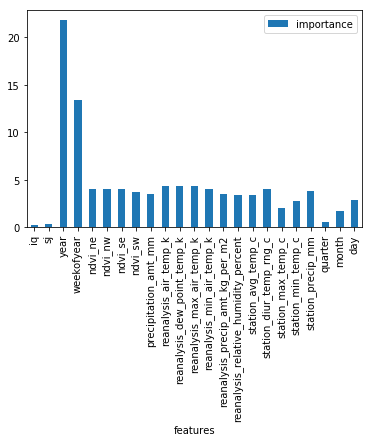

In [28]:
# observe features importance
pd.DataFrame(data={'features':X_train.columns, 'importance':model.feature_importances_}).plot.bar(x='features', y='importance')
plt.show()

### Step 5: train the model again using all training data and do prediction for the 'submit' set

In [29]:
# train test split for train, and cv
X_train, X_cv, y_train, y_cv = train_test_split(training.drop(['total_cases'], axis=1), training.total_cases, test_size=0.3, stratify=training.city, random_state=123)
X_train.drop('city', axis=1, inplace=True)
X_cv.drop('city', axis=1, inplace=True)

In [30]:
# build model
model = CatBoostRegressor(iterations = 4000, learning_rate = 0.3, loss_function='MAE', eval_metric='MAE', use_best_model=True, random_seed=123)
model.fit(X_train, y_train, eval_set=(X_cv, y_cv), verbose=1)

0:	learn: 24.1974352	test: 25.3920835	best: 25.3920835 (0)	total: 30.3ms	remaining: 2m 1s
1:	learn: 24.0744886	test: 25.2775173	best: 25.2775173 (1)	total: 62.2ms	remaining: 2m 4s
2:	learn: 23.9612315	test: 25.1710107	best: 25.1710107 (2)	total: 96.5ms	remaining: 2m 8s
3:	learn: 23.8469576	test: 25.0655092	best: 25.0655092 (3)	total: 129ms	remaining: 2m 9s
4:	learn: 23.7201477	test: 24.9454754	best: 24.9454754 (4)	total: 161ms	remaining: 2m 8s
5:	learn: 23.6047111	test: 24.8404418	best: 24.8404418 (5)	total: 197ms	remaining: 2m 11s
6:	learn: 23.4851525	test: 24.7287017	best: 24.7287017 (6)	total: 231ms	remaining: 2m 11s
7:	learn: 23.3732312	test: 24.6276916	best: 24.6276916 (7)	total: 273ms	remaining: 2m 16s
8:	learn: 23.2610199	test: 24.5244938	best: 24.5244938 (8)	total: 331ms	remaining: 2m 26s
9:	learn: 23.1545849	test: 24.4284554	best: 24.4284554 (9)	total: 373ms	remaining: 2m 28s
10:	learn: 23.0505472	test: 24.3327020	best: 24.3327020 (10)	total: 402ms	remaining: 2m 25s
11:	learn:

93:	learn: 17.8747958	test: 19.3960916	best: 19.3960916 (93)	total: 3.34s	remaining: 2m 18s
94:	learn: 17.8406954	test: 19.3613216	best: 19.3613216 (94)	total: 3.39s	remaining: 2m 19s
95:	learn: 17.8072769	test: 19.3269652	best: 19.3269652 (95)	total: 3.42s	remaining: 2m 19s
96:	learn: 17.7683909	test: 19.2875523	best: 19.2875523 (96)	total: 3.46s	remaining: 2m 19s
97:	learn: 17.7264961	test: 19.2490890	best: 19.2490890 (97)	total: 3.49s	remaining: 2m 18s
98:	learn: 17.6903672	test: 19.2148055	best: 19.2148055 (98)	total: 3.52s	remaining: 2m 18s
99:	learn: 17.6539863	test: 19.1792789	best: 19.1792789 (99)	total: 3.55s	remaining: 2m 18s
100:	learn: 17.6202863	test: 19.1507177	best: 19.1507177 (100)	total: 3.59s	remaining: 2m 18s
101:	learn: 17.5854204	test: 19.1169710	best: 19.1169710 (101)	total: 3.63s	remaining: 2m 18s
102:	learn: 17.5506719	test: 19.0862155	best: 19.0862155 (102)	total: 3.66s	remaining: 2m 18s
103:	learn: 17.5185499	test: 19.0553225	best: 19.0553225 (103)	total: 3.7s

182:	learn: 15.3458558	test: 17.1237944	best: 17.1237944 (182)	total: 6.67s	remaining: 2m 19s
183:	learn: 15.3261718	test: 17.1074323	best: 17.1074323 (183)	total: 6.71s	remaining: 2m 19s
184:	learn: 15.3089777	test: 17.0953402	best: 17.0953402 (184)	total: 6.75s	remaining: 2m 19s
185:	learn: 15.2872848	test: 17.0774478	best: 17.0774478 (185)	total: 6.79s	remaining: 2m 19s
186:	learn: 15.2624927	test: 17.0577768	best: 17.0577768 (186)	total: 6.85s	remaining: 2m 19s
187:	learn: 15.2434304	test: 17.0445437	best: 17.0445437 (187)	total: 6.92s	remaining: 2m 20s
188:	learn: 15.2333390	test: 17.0344447	best: 17.0344447 (188)	total: 6.99s	remaining: 2m 20s
189:	learn: 15.2147664	test: 17.0173182	best: 17.0173182 (189)	total: 7.06s	remaining: 2m 21s
190:	learn: 15.1956938	test: 17.0027418	best: 17.0027418 (190)	total: 7.12s	remaining: 2m 22s
191:	learn: 15.1728505	test: 16.9829012	best: 16.9829012 (191)	total: 7.18s	remaining: 2m 22s
192:	learn: 15.1571498	test: 16.9714818	best: 16.9714818 (19

271:	learn: 14.1094901	test: 16.0805673	best: 16.0805673 (271)	total: 10.2s	remaining: 2m 19s
272:	learn: 14.1008230	test: 16.0740232	best: 16.0740232 (272)	total: 10.2s	remaining: 2m 19s
273:	learn: 14.0960713	test: 16.0685506	best: 16.0685506 (273)	total: 10.3s	remaining: 2m 19s
274:	learn: 14.0896625	test: 16.0632638	best: 16.0632638 (274)	total: 10.3s	remaining: 2m 19s
275:	learn: 14.0808139	test: 16.0590277	best: 16.0590277 (275)	total: 10.3s	remaining: 2m 19s
276:	learn: 14.0724736	test: 16.0527767	best: 16.0527767 (276)	total: 10.4s	remaining: 2m 19s
277:	learn: 14.0628844	test: 16.0446603	best: 16.0446603 (277)	total: 10.4s	remaining: 2m 19s
278:	learn: 14.0582790	test: 16.0395079	best: 16.0395079 (278)	total: 10.4s	remaining: 2m 19s
279:	learn: 14.0469560	test: 16.0306884	best: 16.0306884 (279)	total: 10.5s	remaining: 2m 18s
280:	learn: 14.0387250	test: 16.0214788	best: 16.0214788 (280)	total: 10.5s	remaining: 2m 18s
281:	learn: 14.0335432	test: 16.0160223	best: 16.0160223 (28

360:	learn: 13.4941092	test: 15.6125428	best: 15.6125428 (360)	total: 13.4s	remaining: 2m 14s
361:	learn: 13.4836076	test: 15.6050896	best: 15.6050896 (361)	total: 13.4s	remaining: 2m 14s
362:	learn: 13.4779710	test: 15.6031165	best: 15.6031165 (362)	total: 13.4s	remaining: 2m 14s
363:	learn: 13.4703509	test: 15.5972136	best: 15.5972136 (363)	total: 13.5s	remaining: 2m 14s
364:	learn: 13.4636128	test: 15.5950681	best: 15.5950681 (364)	total: 13.5s	remaining: 2m 14s
365:	learn: 13.4584644	test: 15.5923118	best: 15.5923118 (365)	total: 13.5s	remaining: 2m 14s
366:	learn: 13.4533658	test: 15.5903360	best: 15.5903360 (366)	total: 13.5s	remaining: 2m 14s
367:	learn: 13.4418737	test: 15.5782366	best: 15.5782366 (367)	total: 13.6s	remaining: 2m 14s
368:	learn: 13.4354385	test: 15.5755150	best: 15.5755150 (368)	total: 13.6s	remaining: 2m 13s
369:	learn: 13.4259317	test: 15.5670985	best: 15.5670985 (369)	total: 13.6s	remaining: 2m 13s
370:	learn: 13.4195157	test: 15.5634507	best: 15.5634507 (37

449:	learn: 13.0384799	test: 15.3373331	best: 15.3373331 (449)	total: 16.2s	remaining: 2m 8s
450:	learn: 13.0334884	test: 15.3349681	best: 15.3349681 (450)	total: 16.3s	remaining: 2m 8s
451:	learn: 13.0298543	test: 15.3329686	best: 15.3329686 (451)	total: 16.3s	remaining: 2m 8s
452:	learn: 13.0266019	test: 15.3325776	best: 15.3325776 (452)	total: 16.3s	remaining: 2m 7s
453:	learn: 13.0159504	test: 15.3290377	best: 15.3290377 (453)	total: 16.4s	remaining: 2m 7s
454:	learn: 13.0128286	test: 15.3274748	best: 15.3274748 (454)	total: 16.4s	remaining: 2m 7s
455:	learn: 13.0102377	test: 15.3253930	best: 15.3253930 (455)	total: 16.4s	remaining: 2m 7s
456:	learn: 13.0084598	test: 15.3240907	best: 15.3240907 (456)	total: 16.5s	remaining: 2m 7s
457:	learn: 13.0055385	test: 15.3225171	best: 15.3225171 (457)	total: 16.5s	remaining: 2m 7s
458:	learn: 13.0029302	test: 15.3211662	best: 15.3211662 (458)	total: 16.5s	remaining: 2m 7s
459:	learn: 13.0018137	test: 15.3195917	best: 15.3195917 (459)	total: 

544:	learn: 12.6203289	test: 15.1001714	best: 15.1001714 (544)	total: 19.5s	remaining: 2m 3s
545:	learn: 12.6180469	test: 15.0994114	best: 15.0994114 (545)	total: 19.5s	remaining: 2m 3s
546:	learn: 12.6147072	test: 15.0979444	best: 15.0979444 (546)	total: 19.6s	remaining: 2m 3s
547:	learn: 12.6082497	test: 15.0927490	best: 15.0927490 (547)	total: 19.6s	remaining: 2m 3s
548:	learn: 12.6067229	test: 15.0915644	best: 15.0915644 (548)	total: 19.6s	remaining: 2m 3s
549:	learn: 12.6033282	test: 15.0899046	best: 15.0899046 (549)	total: 19.6s	remaining: 2m 3s
550:	learn: 12.6000472	test: 15.0883674	best: 15.0883674 (550)	total: 19.7s	remaining: 2m 3s
551:	learn: 12.5984457	test: 15.0866322	best: 15.0866322 (551)	total: 19.7s	remaining: 2m 3s
552:	learn: 12.5916120	test: 15.0818170	best: 15.0818170 (552)	total: 19.7s	remaining: 2m 2s
553:	learn: 12.5884108	test: 15.0804683	best: 15.0804683 (553)	total: 19.8s	remaining: 2m 2s
554:	learn: 12.5839084	test: 15.0773129	best: 15.0773129 (554)	total: 

636:	learn: 12.2485555	test: 14.8623320	best: 14.8623320 (636)	total: 22.6s	remaining: 1m 59s
637:	learn: 12.2469737	test: 14.8620465	best: 14.8620465 (637)	total: 22.6s	remaining: 1m 59s
638:	learn: 12.2443821	test: 14.8610833	best: 14.8610833 (638)	total: 22.6s	remaining: 1m 59s
639:	learn: 12.2420583	test: 14.8598640	best: 14.8598640 (639)	total: 22.7s	remaining: 1m 59s
640:	learn: 12.2396157	test: 14.8588529	best: 14.8588529 (640)	total: 22.7s	remaining: 1m 58s
641:	learn: 12.2381757	test: 14.8587387	best: 14.8587387 (641)	total: 22.7s	remaining: 1m 58s
642:	learn: 12.2356374	test: 14.8613059	best: 14.8587387 (641)	total: 22.8s	remaining: 1m 58s
643:	learn: 12.2332049	test: 14.8628061	best: 14.8587387 (641)	total: 22.8s	remaining: 1m 58s
644:	learn: 12.2288071	test: 14.8587694	best: 14.8587387 (641)	total: 22.8s	remaining: 1m 58s
645:	learn: 12.2264995	test: 14.8585418	best: 14.8585418 (645)	total: 22.8s	remaining: 1m 58s
646:	learn: 12.2223972	test: 14.8584116	best: 14.8584116 (64

725:	learn: 11.9343181	test: 14.6924095	best: 14.6917657 (724)	total: 25.4s	remaining: 1m 54s
726:	learn: 11.9330484	test: 14.6918375	best: 14.6917657 (724)	total: 25.5s	remaining: 1m 54s
727:	learn: 11.9311472	test: 14.6900187	best: 14.6900187 (727)	total: 25.5s	remaining: 1m 54s
728:	learn: 11.9287157	test: 14.6887757	best: 14.6887757 (728)	total: 25.6s	remaining: 1m 54s
729:	learn: 11.9269987	test: 14.6884980	best: 14.6884980 (729)	total: 25.6s	remaining: 1m 54s
730:	learn: 11.9214406	test: 14.6848030	best: 14.6848030 (730)	total: 25.6s	remaining: 1m 54s
731:	learn: 11.9137135	test: 14.6807599	best: 14.6807599 (731)	total: 25.6s	remaining: 1m 54s
732:	learn: 11.9086751	test: 14.6781496	best: 14.6781496 (732)	total: 25.7s	remaining: 1m 54s
733:	learn: 11.9064141	test: 14.6778192	best: 14.6778192 (733)	total: 25.7s	remaining: 1m 54s
734:	learn: 11.9037116	test: 14.6791085	best: 14.6778192 (733)	total: 25.7s	remaining: 1m 54s
735:	learn: 11.9023532	test: 14.6798621	best: 14.6778192 (73

816:	learn: 11.6235959	test: 14.5398127	best: 14.5398127 (816)	total: 28.7s	remaining: 1m 51s
817:	learn: 11.6220019	test: 14.5396379	best: 14.5396379 (817)	total: 28.8s	remaining: 1m 51s
818:	learn: 11.6189069	test: 14.5394239	best: 14.5394239 (818)	total: 28.8s	remaining: 1m 51s
819:	learn: 11.6171832	test: 14.5394499	best: 14.5394239 (818)	total: 28.8s	remaining: 1m 51s
820:	learn: 11.6096716	test: 14.5341621	best: 14.5341621 (820)	total: 28.9s	remaining: 1m 51s
821:	learn: 11.6073678	test: 14.5336727	best: 14.5336727 (821)	total: 28.9s	remaining: 1m 51s
822:	learn: 11.6010742	test: 14.5283664	best: 14.5283664 (822)	total: 28.9s	remaining: 1m 51s
823:	learn: 11.5994695	test: 14.5282579	best: 14.5282579 (823)	total: 29s	remaining: 1m 51s
824:	learn: 11.5962101	test: 14.5273919	best: 14.5273919 (824)	total: 29s	remaining: 1m 51s
825:	learn: 11.5905096	test: 14.5245146	best: 14.5245146 (825)	total: 29s	remaining: 1m 51s
826:	learn: 11.5870237	test: 14.5216292	best: 14.5216292 (826)	tot

905:	learn: 11.3668734	test: 14.4286964	best: 14.4286964 (905)	total: 32s	remaining: 1m 49s
906:	learn: 11.3653245	test: 14.4286618	best: 14.4286618 (906)	total: 32s	remaining: 1m 49s
907:	learn: 11.3637937	test: 14.4291299	best: 14.4286618 (906)	total: 32s	remaining: 1m 49s
908:	learn: 11.3588464	test: 14.4281776	best: 14.4281776 (908)	total: 32.1s	remaining: 1m 49s
909:	learn: 11.3550865	test: 14.4260648	best: 14.4260648 (909)	total: 32.1s	remaining: 1m 48s
910:	learn: 11.3541595	test: 14.4247542	best: 14.4247542 (910)	total: 32.1s	remaining: 1m 48s
911:	learn: 11.3509172	test: 14.4238003	best: 14.4238003 (911)	total: 32.2s	remaining: 1m 48s
912:	learn: 11.3498702	test: 14.4242303	best: 14.4238003 (911)	total: 32.2s	remaining: 1m 48s
913:	learn: 11.3461624	test: 14.4198087	best: 14.4198087 (913)	total: 32.2s	remaining: 1m 48s
914:	learn: 11.3413577	test: 14.4169522	best: 14.4169522 (914)	total: 32.3s	remaining: 1m 48s
915:	learn: 11.3389501	test: 14.4157773	best: 14.4157773 (915)	tot

999:	learn: 11.1427962	test: 14.3423671	best: 14.3423671 (999)	total: 35.4s	remaining: 1m 46s
1000:	learn: 11.1401767	test: 14.3424097	best: 14.3423671 (999)	total: 35.5s	remaining: 1m 46s
1001:	learn: 11.1384433	test: 14.3421177	best: 14.3421177 (1001)	total: 35.5s	remaining: 1m 46s
1002:	learn: 11.1307079	test: 14.3381760	best: 14.3381760 (1002)	total: 35.6s	remaining: 1m 46s
1003:	learn: 11.1233446	test: 14.3328372	best: 14.3328372 (1003)	total: 35.6s	remaining: 1m 46s
1004:	learn: 11.1168374	test: 14.3277600	best: 14.3277600 (1004)	total: 35.6s	remaining: 1m 46s
1005:	learn: 11.1156361	test: 14.3283054	best: 14.3277600 (1004)	total: 35.7s	remaining: 1m 46s
1006:	learn: 11.1134670	test: 14.3295546	best: 14.3277600 (1004)	total: 35.7s	remaining: 1m 46s
1007:	learn: 11.1119331	test: 14.3279274	best: 14.3277600 (1004)	total: 35.8s	remaining: 1m 46s
1008:	learn: 11.1096269	test: 14.3290037	best: 14.3277600 (1004)	total: 35.8s	remaining: 1m 46s
1009:	learn: 11.1084837	test: 14.3287233	be

1086:	learn: 10.9467606	test: 14.2754649	best: 14.2728302 (1080)	total: 38.5s	remaining: 1m 43s
1087:	learn: 10.9371876	test: 14.2697870	best: 14.2697870 (1087)	total: 38.5s	remaining: 1m 43s
1088:	learn: 10.9359998	test: 14.2697549	best: 14.2697549 (1088)	total: 38.5s	remaining: 1m 43s
1089:	learn: 10.9328862	test: 14.2690525	best: 14.2690525 (1089)	total: 38.6s	remaining: 1m 42s
1090:	learn: 10.9312086	test: 14.2672428	best: 14.2672428 (1090)	total: 38.6s	remaining: 1m 42s
1091:	learn: 10.9288386	test: 14.2682469	best: 14.2672428 (1090)	total: 38.6s	remaining: 1m 42s
1092:	learn: 10.9275990	test: 14.2674279	best: 14.2672428 (1090)	total: 38.6s	remaining: 1m 42s
1093:	learn: 10.9262285	test: 14.2661016	best: 14.2661016 (1093)	total: 38.7s	remaining: 1m 42s
1094:	learn: 10.9254614	test: 14.2660244	best: 14.2660244 (1094)	total: 38.7s	remaining: 1m 42s
1095:	learn: 10.9193177	test: 14.2646927	best: 14.2646927 (1095)	total: 38.7s	remaining: 1m 42s
1096:	learn: 10.9159466	test: 14.2623118

1175:	learn: 10.7241625	test: 14.1920675	best: 14.1920058 (1174)	total: 41.5s	remaining: 1m 39s
1176:	learn: 10.7223323	test: 14.1906533	best: 14.1906533 (1176)	total: 41.6s	remaining: 1m 39s
1177:	learn: 10.7208807	test: 14.1899664	best: 14.1899664 (1177)	total: 41.6s	remaining: 1m 39s
1178:	learn: 10.7196316	test: 14.1907359	best: 14.1899664 (1177)	total: 41.6s	remaining: 1m 39s
1179:	learn: 10.7181603	test: 14.1904275	best: 14.1899664 (1177)	total: 41.7s	remaining: 1m 39s
1180:	learn: 10.7163777	test: 14.1902800	best: 14.1899664 (1177)	total: 41.7s	remaining: 1m 39s
1181:	learn: 10.7153131	test: 14.1891809	best: 14.1891809 (1181)	total: 41.7s	remaining: 1m 39s
1182:	learn: 10.7132082	test: 14.1896155	best: 14.1891809 (1181)	total: 41.8s	remaining: 1m 39s
1183:	learn: 10.7102071	test: 14.1901930	best: 14.1891809 (1181)	total: 41.8s	remaining: 1m 39s
1184:	learn: 10.7087103	test: 14.1900533	best: 14.1891809 (1181)	total: 41.8s	remaining: 1m 39s
1185:	learn: 10.7074896	test: 14.1895281

1266:	learn: 10.5579755	test: 14.1446951	best: 14.1435936 (1265)	total: 44.7s	remaining: 1m 36s
1267:	learn: 10.5575613	test: 14.1449430	best: 14.1435936 (1265)	total: 44.8s	remaining: 1m 36s
1268:	learn: 10.5556109	test: 14.1454439	best: 14.1435936 (1265)	total: 44.8s	remaining: 1m 36s
1269:	learn: 10.5548188	test: 14.1459004	best: 14.1435936 (1265)	total: 44.8s	remaining: 1m 36s
1270:	learn: 10.5543464	test: 14.1456090	best: 14.1435936 (1265)	total: 44.9s	remaining: 1m 36s
1271:	learn: 10.5510600	test: 14.1455159	best: 14.1435936 (1265)	total: 44.9s	remaining: 1m 36s
1272:	learn: 10.5477661	test: 14.1440166	best: 14.1435936 (1265)	total: 44.9s	remaining: 1m 36s
1273:	learn: 10.5445338	test: 14.1413175	best: 14.1413175 (1273)	total: 45s	remaining: 1m 36s
1274:	learn: 10.5434059	test: 14.1399916	best: 14.1399916 (1274)	total: 45s	remaining: 1m 36s
1275:	learn: 10.5402819	test: 14.1356826	best: 14.1356826 (1275)	total: 45s	remaining: 1m 36s
1276:	learn: 10.5360445	test: 14.1357694	best:

1354:	learn: 10.4019152	test: 14.0780684	best: 14.0780684 (1354)	total: 47.7s	remaining: 1m 33s
1355:	learn: 10.4010487	test: 14.0780706	best: 14.0780684 (1354)	total: 47.8s	remaining: 1m 33s
1356:	learn: 10.3982629	test: 14.0761559	best: 14.0761559 (1356)	total: 47.8s	remaining: 1m 33s
1357:	learn: 10.3959976	test: 14.0766533	best: 14.0761559 (1356)	total: 47.9s	remaining: 1m 33s
1358:	learn: 10.3927330	test: 14.0740301	best: 14.0740301 (1358)	total: 47.9s	remaining: 1m 33s
1359:	learn: 10.3916669	test: 14.0736769	best: 14.0736769 (1359)	total: 48s	remaining: 1m 33s
1360:	learn: 10.3908756	test: 14.0730719	best: 14.0730719 (1360)	total: 48s	remaining: 1m 33s
1361:	learn: 10.3881206	test: 14.0733025	best: 14.0730719 (1360)	total: 48.1s	remaining: 1m 33s
1362:	learn: 10.3872017	test: 14.0726029	best: 14.0726029 (1362)	total: 48.1s	remaining: 1m 33s
1363:	learn: 10.3859594	test: 14.0726879	best: 14.0726029 (1362)	total: 48.1s	remaining: 1m 33s
1364:	learn: 10.3835924	test: 14.0728355	bes

1443:	learn: 10.2631033	test: 14.0385268	best: 14.0368175 (1439)	total: 50.5s	remaining: 1m 29s
1444:	learn: 10.2604300	test: 14.0371484	best: 14.0368175 (1439)	total: 50.6s	remaining: 1m 29s
1445:	learn: 10.2580523	test: 14.0368714	best: 14.0368175 (1439)	total: 50.6s	remaining: 1m 29s
1446:	learn: 10.2559517	test: 14.0344023	best: 14.0344023 (1446)	total: 50.6s	remaining: 1m 29s
1447:	learn: 10.2525311	test: 14.0330987	best: 14.0330987 (1447)	total: 50.7s	remaining: 1m 29s
1448:	learn: 10.2497948	test: 14.0308770	best: 14.0308770 (1448)	total: 50.7s	remaining: 1m 29s
1449:	learn: 10.2457619	test: 14.0294522	best: 14.0294522 (1449)	total: 50.7s	remaining: 1m 29s
1450:	learn: 10.2436788	test: 14.0278608	best: 14.0278608 (1450)	total: 50.7s	remaining: 1m 29s
1451:	learn: 10.2424791	test: 14.0281724	best: 14.0278608 (1450)	total: 50.8s	remaining: 1m 29s
1452:	learn: 10.2388090	test: 14.0268332	best: 14.0268332 (1452)	total: 50.8s	remaining: 1m 29s
1453:	learn: 10.2380640	test: 14.0271317

1531:	learn: 10.1231094	test: 13.9948148	best: 13.9899738 (1520)	total: 53.1s	remaining: 1m 25s
1532:	learn: 10.1192825	test: 13.9930238	best: 13.9899738 (1520)	total: 53.1s	remaining: 1m 25s
1533:	learn: 10.1175569	test: 13.9927946	best: 13.9899738 (1520)	total: 53.2s	remaining: 1m 25s
1534:	learn: 10.1162852	test: 13.9915238	best: 13.9899738 (1520)	total: 53.2s	remaining: 1m 25s
1535:	learn: 10.1145261	test: 13.9904513	best: 13.9899738 (1520)	total: 53.2s	remaining: 1m 25s
1536:	learn: 10.1129692	test: 13.9909000	best: 13.9899738 (1520)	total: 53.3s	remaining: 1m 25s
1537:	learn: 10.1117422	test: 13.9898909	best: 13.9898909 (1537)	total: 53.3s	remaining: 1m 25s
1538:	learn: 10.1114349	test: 13.9903025	best: 13.9898909 (1537)	total: 53.3s	remaining: 1m 25s
1539:	learn: 10.1104381	test: 13.9914261	best: 13.9898909 (1537)	total: 53.3s	remaining: 1m 25s
1540:	learn: 10.1086336	test: 13.9887033	best: 13.9887033 (1540)	total: 53.4s	remaining: 1m 25s
1541:	learn: 10.1081349	test: 13.9885001

1621:	learn: 9.9774108	test: 13.9495222	best: 13.9495222 (1621)	total: 56.4s	remaining: 1m 22s
1622:	learn: 9.9763583	test: 13.9486453	best: 13.9486453 (1622)	total: 56.4s	remaining: 1m 22s
1623:	learn: 9.9747496	test: 13.9482166	best: 13.9482166 (1623)	total: 56.5s	remaining: 1m 22s
1624:	learn: 9.9710752	test: 13.9460926	best: 13.9460926 (1624)	total: 56.6s	remaining: 1m 22s
1625:	learn: 9.9703148	test: 13.9463448	best: 13.9460926 (1624)	total: 56.6s	remaining: 1m 22s
1626:	learn: 9.9701569	test: 13.9463629	best: 13.9460926 (1624)	total: 56.7s	remaining: 1m 22s
1627:	learn: 9.9691090	test: 13.9457143	best: 13.9457143 (1627)	total: 56.7s	remaining: 1m 22s
1628:	learn: 9.9683672	test: 13.9449771	best: 13.9449771 (1628)	total: 56.7s	remaining: 1m 22s
1629:	learn: 9.9675044	test: 13.9443284	best: 13.9443284 (1629)	total: 56.8s	remaining: 1m 22s
1630:	learn: 9.9659712	test: 13.9429318	best: 13.9429318 (1630)	total: 56.8s	remaining: 1m 22s
1631:	learn: 9.9654714	test: 13.9424914	best: 13.9

1709:	learn: 9.8462917	test: 13.8970714	best: 13.8965057 (1708)	total: 59.4s	remaining: 1m 19s
1710:	learn: 9.8449854	test: 13.8972651	best: 13.8965057 (1708)	total: 59.4s	remaining: 1m 19s
1711:	learn: 9.8446552	test: 13.8974060	best: 13.8965057 (1708)	total: 59.5s	remaining: 1m 19s
1712:	learn: 9.8435442	test: 13.8965284	best: 13.8965057 (1708)	total: 59.6s	remaining: 1m 19s
1713:	learn: 9.8405638	test: 13.8926493	best: 13.8926493 (1713)	total: 59.7s	remaining: 1m 19s
1714:	learn: 9.8395664	test: 13.8928903	best: 13.8926493 (1713)	total: 59.7s	remaining: 1m 19s
1715:	learn: 9.8387845	test: 13.8927526	best: 13.8926493 (1713)	total: 59.7s	remaining: 1m 19s
1716:	learn: 9.8366151	test: 13.8907426	best: 13.8907426 (1716)	total: 59.8s	remaining: 1m 19s
1717:	learn: 9.8352431	test: 13.8902969	best: 13.8902969 (1717)	total: 59.8s	remaining: 1m 19s
1718:	learn: 9.8332346	test: 13.8906223	best: 13.8902969 (1717)	total: 59.9s	remaining: 1m 19s
1719:	learn: 9.8323406	test: 13.8911099	best: 13.8

1797:	learn: 9.7273156	test: 13.8759724	best: 13.8743736 (1757)	total: 1m 3s	remaining: 1m 18s
1798:	learn: 9.7243684	test: 13.8739414	best: 13.8739414 (1798)	total: 1m 3s	remaining: 1m 18s
1799:	learn: 9.7214278	test: 13.8730803	best: 13.8730803 (1799)	total: 1m 3s	remaining: 1m 18s
1800:	learn: 9.7205135	test: 13.8729863	best: 13.8729863 (1800)	total: 1m 3s	remaining: 1m 18s
1801:	learn: 9.7197395	test: 13.8730474	best: 13.8729863 (1800)	total: 1m 3s	remaining: 1m 17s
1802:	learn: 9.7185014	test: 13.8744668	best: 13.8729863 (1800)	total: 1m 3s	remaining: 1m 17s
1803:	learn: 9.7172761	test: 13.8740469	best: 13.8729863 (1800)	total: 1m 4s	remaining: 1m 17s
1804:	learn: 9.7160606	test: 13.8726107	best: 13.8726107 (1804)	total: 1m 4s	remaining: 1m 17s
1805:	learn: 9.7150250	test: 13.8727142	best: 13.8726107 (1804)	total: 1m 4s	remaining: 1m 17s
1806:	learn: 9.7136357	test: 13.8732283	best: 13.8726107 (1804)	total: 1m 4s	remaining: 1m 17s
1807:	learn: 9.7115650	test: 13.8723893	best: 13.8

1889:	learn: 9.6009829	test: 13.8472935	best: 13.8464148 (1888)	total: 1m 6s	remaining: 1m 14s
1890:	learn: 9.6000136	test: 13.8476125	best: 13.8464148 (1888)	total: 1m 6s	remaining: 1m 14s
1891:	learn: 9.5990811	test: 13.8484530	best: 13.8464148 (1888)	total: 1m 6s	remaining: 1m 14s
1892:	learn: 9.5973269	test: 13.8490060	best: 13.8464148 (1888)	total: 1m 6s	remaining: 1m 14s
1893:	learn: 9.5961835	test: 13.8480093	best: 13.8464148 (1888)	total: 1m 6s	remaining: 1m 14s
1894:	learn: 9.5951099	test: 13.8470179	best: 13.8464148 (1888)	total: 1m 6s	remaining: 1m 14s
1895:	learn: 9.5921332	test: 13.8476649	best: 13.8464148 (1888)	total: 1m 6s	remaining: 1m 14s
1896:	learn: 9.5913011	test: 13.8476769	best: 13.8464148 (1888)	total: 1m 7s	remaining: 1m 14s
1897:	learn: 9.5897549	test: 13.8486744	best: 13.8464148 (1888)	total: 1m 7s	remaining: 1m 14s
1898:	learn: 9.5889681	test: 13.8483588	best: 13.8464148 (1888)	total: 1m 7s	remaining: 1m 14s
1899:	learn: 9.5875178	test: 13.8489922	best: 13.8

1981:	learn: 9.4792738	test: 13.8336044	best: 13.8326883 (1953)	total: 1m 9s	remaining: 1m 11s
1982:	learn: 9.4786382	test: 13.8343955	best: 13.8326883 (1953)	total: 1m 10s	remaining: 1m 11s
1983:	learn: 9.4777926	test: 13.8352744	best: 13.8326883 (1953)	total: 1m 10s	remaining: 1m 11s
1984:	learn: 9.4770675	test: 13.8348971	best: 13.8326883 (1953)	total: 1m 10s	remaining: 1m 11s
1985:	learn: 9.4755459	test: 13.8355181	best: 13.8326883 (1953)	total: 1m 10s	remaining: 1m 11s
1986:	learn: 9.4742986	test: 13.8351248	best: 13.8326883 (1953)	total: 1m 10s	remaining: 1m 11s
1987:	learn: 9.4714866	test: 13.8330015	best: 13.8326883 (1953)	total: 1m 10s	remaining: 1m 11s
1988:	learn: 9.4687831	test: 13.8321735	best: 13.8321735 (1988)	total: 1m 10s	remaining: 1m 10s
1989:	learn: 9.4652541	test: 13.8344167	best: 13.8321735 (1988)	total: 1m 10s	remaining: 1m 10s
1990:	learn: 9.4623151	test: 13.8306743	best: 13.8306743 (1990)	total: 1m 10s	remaining: 1m 10s
1991:	learn: 9.4601889	test: 13.8308725	b

2070:	learn: 9.3589295	test: 13.8158998	best: 13.8142198 (2058)	total: 1m 12s	remaining: 1m 7s
2071:	learn: 9.3572909	test: 13.8170432	best: 13.8142198 (2058)	total: 1m 12s	remaining: 1m 7s
2072:	learn: 9.3555950	test: 13.8166121	best: 13.8142198 (2058)	total: 1m 12s	remaining: 1m 7s
2073:	learn: 9.3547313	test: 13.8163634	best: 13.8142198 (2058)	total: 1m 12s	remaining: 1m 7s
2074:	learn: 9.3526840	test: 13.8139703	best: 13.8139703 (2074)	total: 1m 12s	remaining: 1m 7s
2075:	learn: 9.3507463	test: 13.8153083	best: 13.8139703 (2074)	total: 1m 12s	remaining: 1m 7s
2076:	learn: 9.3497928	test: 13.8153557	best: 13.8139703 (2074)	total: 1m 12s	remaining: 1m 7s
2077:	learn: 9.3477442	test: 13.8150837	best: 13.8139703 (2074)	total: 1m 12s	remaining: 1m 7s
2078:	learn: 9.3469704	test: 13.8145899	best: 13.8139703 (2074)	total: 1m 13s	remaining: 1m 7s
2079:	learn: 9.3458827	test: 13.8155799	best: 13.8139703 (2074)	total: 1m 13s	remaining: 1m 7s
2080:	learn: 9.3426289	test: 13.8130150	best: 13.8

2163:	learn: 9.2394913	test: 13.7962442	best: 13.7947733 (2159)	total: 1m 15s	remaining: 1m 4s
2164:	learn: 9.2379802	test: 13.7955746	best: 13.7947733 (2159)	total: 1m 15s	remaining: 1m 4s
2165:	learn: 9.2364283	test: 13.7948296	best: 13.7947733 (2159)	total: 1m 15s	remaining: 1m 4s
2166:	learn: 9.2361571	test: 13.7950071	best: 13.7947733 (2159)	total: 1m 15s	remaining: 1m 4s
2167:	learn: 9.2344652	test: 13.7932939	best: 13.7932939 (2167)	total: 1m 16s	remaining: 1m 4s
2168:	learn: 9.2334868	test: 13.7924278	best: 13.7924278 (2168)	total: 1m 16s	remaining: 1m 4s
2169:	learn: 9.2329624	test: 13.7915680	best: 13.7915680 (2169)	total: 1m 16s	remaining: 1m 4s
2170:	learn: 9.2299360	test: 13.7915357	best: 13.7915357 (2170)	total: 1m 16s	remaining: 1m 4s
2171:	learn: 9.2281284	test: 13.7904485	best: 13.7904485 (2171)	total: 1m 16s	remaining: 1m 4s
2172:	learn: 9.2276434	test: 13.7892794	best: 13.7892794 (2172)	total: 1m 16s	remaining: 1m 4s
2173:	learn: 9.2253222	test: 13.7876177	best: 13.7

2253:	learn: 9.1240007	test: 13.7805459	best: 13.7758780 (2220)	total: 1m 18s	remaining: 1m 1s
2254:	learn: 9.1233729	test: 13.7817778	best: 13.7758780 (2220)	total: 1m 18s	remaining: 1m 1s
2255:	learn: 9.1222182	test: 13.7826930	best: 13.7758780 (2220)	total: 1m 18s	remaining: 1m 1s
2256:	learn: 9.1210820	test: 13.7834683	best: 13.7758780 (2220)	total: 1m 18s	remaining: 1m
2257:	learn: 9.1209137	test: 13.7834914	best: 13.7758780 (2220)	total: 1m 18s	remaining: 1m
2258:	learn: 9.1204535	test: 13.7826408	best: 13.7758780 (2220)	total: 1m 19s	remaining: 1m
2259:	learn: 9.1195245	test: 13.7824598	best: 13.7758780 (2220)	total: 1m 19s	remaining: 1m
2260:	learn: 9.1192708	test: 13.7830358	best: 13.7758780 (2220)	total: 1m 19s	remaining: 1m
2261:	learn: 9.1187124	test: 13.7828961	best: 13.7758780 (2220)	total: 1m 19s	remaining: 1m
2262:	learn: 9.1162926	test: 13.7800106	best: 13.7758780 (2220)	total: 1m 19s	remaining: 1m
2263:	learn: 9.1146887	test: 13.7791285	best: 13.7758780 (2220)	total: 

2346:	learn: 9.0209793	test: 13.7685359	best: 13.7649305 (2337)	total: 1m 21s	remaining: 57.7s
2347:	learn: 9.0203064	test: 13.7687865	best: 13.7649305 (2337)	total: 1m 21s	remaining: 57.6s
2348:	learn: 9.0184244	test: 13.7702289	best: 13.7649305 (2337)	total: 1m 21s	remaining: 57.6s
2349:	learn: 9.0183405	test: 13.7708528	best: 13.7649305 (2337)	total: 1m 21s	remaining: 57.6s
2350:	learn: 9.0181825	test: 13.7702145	best: 13.7649305 (2337)	total: 1m 22s	remaining: 57.5s
2351:	learn: 9.0173983	test: 13.7714237	best: 13.7649305 (2337)	total: 1m 22s	remaining: 57.5s
2352:	learn: 9.0163836	test: 13.7711956	best: 13.7649305 (2337)	total: 1m 22s	remaining: 57.5s
2353:	learn: 9.0148295	test: 13.7720904	best: 13.7649305 (2337)	total: 1m 22s	remaining: 57.4s
2354:	learn: 9.0136567	test: 13.7721328	best: 13.7649305 (2337)	total: 1m 22s	remaining: 57.4s
2355:	learn: 9.0134077	test: 13.7717197	best: 13.7649305 (2337)	total: 1m 22s	remaining: 57.4s
2356:	learn: 9.0119088	test: 13.7701176	best: 13.7

2434:	learn: 8.9221082	test: 13.7620083	best: 13.7601252 (2420)	total: 1m 24s	remaining: 54.5s
2435:	learn: 8.9200883	test: 13.7634845	best: 13.7601252 (2420)	total: 1m 24s	remaining: 54.4s
2436:	learn: 8.9191334	test: 13.7624056	best: 13.7601252 (2420)	total: 1m 24s	remaining: 54.4s
2437:	learn: 8.9181490	test: 13.7622849	best: 13.7601252 (2420)	total: 1m 24s	remaining: 54.3s
2438:	learn: 8.9170896	test: 13.7628704	best: 13.7601252 (2420)	total: 1m 24s	remaining: 54.3s
2439:	learn: 8.9163285	test: 13.7616320	best: 13.7601252 (2420)	total: 1m 24s	remaining: 54.3s
2440:	learn: 8.9155250	test: 13.7610202	best: 13.7601252 (2420)	total: 1m 24s	remaining: 54.2s
2441:	learn: 8.9152183	test: 13.7617186	best: 13.7601252 (2420)	total: 1m 24s	remaining: 54.2s
2442:	learn: 8.9135973	test: 13.7615864	best: 13.7601252 (2420)	total: 1m 24s	remaining: 54.2s
2443:	learn: 8.9123271	test: 13.7600244	best: 13.7600244 (2443)	total: 1m 25s	remaining: 54.1s
2444:	learn: 8.9109054	test: 13.7600241	best: 13.7

2524:	learn: 8.8343604	test: 13.7651249	best: 13.7511460 (2474)	total: 1m 27s	remaining: 51.1s
2525:	learn: 8.8337376	test: 13.7648825	best: 13.7511460 (2474)	total: 1m 27s	remaining: 51.1s
2526:	learn: 8.8334094	test: 13.7650090	best: 13.7511460 (2474)	total: 1m 27s	remaining: 51s
2527:	learn: 8.8329230	test: 13.7652726	best: 13.7511460 (2474)	total: 1m 27s	remaining: 51s
2528:	learn: 8.8316452	test: 13.7653555	best: 13.7511460 (2474)	total: 1m 27s	remaining: 51s
2529:	learn: 8.8314808	test: 13.7661359	best: 13.7511460 (2474)	total: 1m 27s	remaining: 50.9s
2530:	learn: 8.8304817	test: 13.7664682	best: 13.7511460 (2474)	total: 1m 27s	remaining: 50.9s
2531:	learn: 8.8300117	test: 13.7660062	best: 13.7511460 (2474)	total: 1m 27s	remaining: 50.8s
2532:	learn: 8.8292452	test: 13.7661774	best: 13.7511460 (2474)	total: 1m 27s	remaining: 50.8s
2533:	learn: 8.8288631	test: 13.7660853	best: 13.7511460 (2474)	total: 1m 27s	remaining: 50.8s
2534:	learn: 8.8277583	test: 13.7668586	best: 13.7511460

2611:	learn: 8.7466774	test: 13.7606700	best: 13.7511460 (2474)	total: 1m 30s	remaining: 47.9s
2612:	learn: 8.7460886	test: 13.7598623	best: 13.7511460 (2474)	total: 1m 30s	remaining: 47.9s
2613:	learn: 8.7449840	test: 13.7605729	best: 13.7511460 (2474)	total: 1m 30s	remaining: 47.9s
2614:	learn: 8.7430711	test: 13.7623010	best: 13.7511460 (2474)	total: 1m 30s	remaining: 47.8s
2615:	learn: 8.7427503	test: 13.7609372	best: 13.7511460 (2474)	total: 1m 30s	remaining: 47.8s
2616:	learn: 8.7418701	test: 13.7617903	best: 13.7511460 (2474)	total: 1m 30s	remaining: 47.7s
2617:	learn: 8.7409013	test: 13.7627560	best: 13.7511460 (2474)	total: 1m 30s	remaining: 47.7s
2618:	learn: 8.7410609	test: 13.7631420	best: 13.7511460 (2474)	total: 1m 30s	remaining: 47.7s
2619:	learn: 8.7403906	test: 13.7626756	best: 13.7511460 (2474)	total: 1m 30s	remaining: 47.6s
2620:	learn: 8.7397514	test: 13.7631468	best: 13.7511460 (2474)	total: 1m 30s	remaining: 47.6s
2621:	learn: 8.7378540	test: 13.7631680	best: 13.7

2701:	learn: 8.6579052	test: 13.7523748	best: 13.7498812 (2690)	total: 1m 33s	remaining: 44.7s
2702:	learn: 8.6574347	test: 13.7517314	best: 13.7498812 (2690)	total: 1m 33s	remaining: 44.7s
2703:	learn: 8.6572279	test: 13.7522744	best: 13.7498812 (2690)	total: 1m 33s	remaining: 44.7s
2704:	learn: 8.6565351	test: 13.7510541	best: 13.7498812 (2690)	total: 1m 33s	remaining: 44.6s
2705:	learn: 8.6560680	test: 13.7496940	best: 13.7496940 (2705)	total: 1m 33s	remaining: 44.6s
2706:	learn: 8.6556076	test: 13.7497731	best: 13.7496940 (2705)	total: 1m 33s	remaining: 44.6s
2707:	learn: 8.6535656	test: 13.7504681	best: 13.7496940 (2705)	total: 1m 33s	remaining: 44.5s
2708:	learn: 8.6527834	test: 13.7510363	best: 13.7496940 (2705)	total: 1m 33s	remaining: 44.5s
2709:	learn: 8.6523782	test: 13.7509811	best: 13.7496940 (2705)	total: 1m 33s	remaining: 44.5s
2710:	learn: 8.6518255	test: 13.7510253	best: 13.7496940 (2705)	total: 1m 33s	remaining: 44.4s
2711:	learn: 8.6513168	test: 13.7503413	best: 13.7

2791:	learn: 8.5666183	test: 13.7455385	best: 13.7445853 (2789)	total: 1m 36s	remaining: 41.7s
2792:	learn: 8.5665973	test: 13.7477815	best: 13.7445853 (2789)	total: 1m 36s	remaining: 41.7s
2793:	learn: 8.5647304	test: 13.7461305	best: 13.7445853 (2789)	total: 1m 36s	remaining: 41.6s
2794:	learn: 8.5634520	test: 13.7448566	best: 13.7445853 (2789)	total: 1m 36s	remaining: 41.6s
2795:	learn: 8.5619539	test: 13.7452263	best: 13.7445853 (2789)	total: 1m 36s	remaining: 41.6s
2796:	learn: 8.5607581	test: 13.7455393	best: 13.7445853 (2789)	total: 1m 36s	remaining: 41.5s
2797:	learn: 8.5598347	test: 13.7440645	best: 13.7440645 (2797)	total: 1m 36s	remaining: 41.5s
2798:	learn: 8.5591769	test: 13.7435751	best: 13.7435751 (2798)	total: 1m 36s	remaining: 41.5s
2799:	learn: 8.5581878	test: 13.7436212	best: 13.7435751 (2798)	total: 1m 36s	remaining: 41.4s
2800:	learn: 8.5569437	test: 13.7452655	best: 13.7435751 (2798)	total: 1m 36s	remaining: 41.4s
2801:	learn: 8.5554784	test: 13.7459295	best: 13.7

2879:	learn: 8.4871280	test: 13.7412716	best: 13.7392653 (2876)	total: 1m 39s	remaining: 38.7s
2880:	learn: 8.4865283	test: 13.7427435	best: 13.7392653 (2876)	total: 1m 39s	remaining: 38.6s
2881:	learn: 8.4860044	test: 13.7439941	best: 13.7392653 (2876)	total: 1m 39s	remaining: 38.6s
2882:	learn: 8.4853838	test: 13.7443538	best: 13.7392653 (2876)	total: 1m 39s	remaining: 38.6s
2883:	learn: 8.4845141	test: 13.7457664	best: 13.7392653 (2876)	total: 1m 39s	remaining: 38.5s
2884:	learn: 8.4844277	test: 13.7458693	best: 13.7392653 (2876)	total: 1m 39s	remaining: 38.5s
2885:	learn: 8.4836616	test: 13.7461767	best: 13.7392653 (2876)	total: 1m 39s	remaining: 38.5s
2886:	learn: 8.4830749	test: 13.7471597	best: 13.7392653 (2876)	total: 1m 39s	remaining: 38.4s
2887:	learn: 8.4822599	test: 13.7460802	best: 13.7392653 (2876)	total: 1m 39s	remaining: 38.4s
2888:	learn: 8.4806205	test: 13.7458320	best: 13.7392653 (2876)	total: 1m 39s	remaining: 38.3s
2889:	learn: 8.4798591	test: 13.7456451	best: 13.7

2967:	learn: 8.3955789	test: 13.7480825	best: 13.7392653 (2876)	total: 1m 42s	remaining: 35.5s
2968:	learn: 8.3953731	test: 13.7485167	best: 13.7392653 (2876)	total: 1m 42s	remaining: 35.5s
2969:	learn: 8.3951282	test: 13.7488170	best: 13.7392653 (2876)	total: 1m 42s	remaining: 35.4s
2970:	learn: 8.3949145	test: 13.7485961	best: 13.7392653 (2876)	total: 1m 42s	remaining: 35.4s
2971:	learn: 8.3944598	test: 13.7489321	best: 13.7392653 (2876)	total: 1m 42s	remaining: 35.4s
2972:	learn: 8.3936067	test: 13.7493362	best: 13.7392653 (2876)	total: 1m 42s	remaining: 35.3s
2973:	learn: 8.3917223	test: 13.7497548	best: 13.7392653 (2876)	total: 1m 42s	remaining: 35.3s
2974:	learn: 8.3913194	test: 13.7495172	best: 13.7392653 (2876)	total: 1m 42s	remaining: 35.3s
2975:	learn: 8.3909011	test: 13.7479611	best: 13.7392653 (2876)	total: 1m 42s	remaining: 35.2s
2976:	learn: 8.3894189	test: 13.7464608	best: 13.7392653 (2876)	total: 1m 42s	remaining: 35.2s
2977:	learn: 8.3884635	test: 13.7473562	best: 13.7

3058:	learn: 8.3222852	test: 13.7441515	best: 13.7392653 (2876)	total: 1m 44s	remaining: 32.3s
3059:	learn: 8.3214898	test: 13.7444114	best: 13.7392653 (2876)	total: 1m 44s	remaining: 32.2s
3060:	learn: 8.3209883	test: 13.7433946	best: 13.7392653 (2876)	total: 1m 44s	remaining: 32.2s
3061:	learn: 8.3207349	test: 13.7435953	best: 13.7392653 (2876)	total: 1m 44s	remaining: 32.2s
3062:	learn: 8.3201464	test: 13.7434173	best: 13.7392653 (2876)	total: 1m 45s	remaining: 32.1s
3063:	learn: 8.3200484	test: 13.7421870	best: 13.7392653 (2876)	total: 1m 45s	remaining: 32.1s
3064:	learn: 8.3195432	test: 13.7425884	best: 13.7392653 (2876)	total: 1m 45s	remaining: 32.1s
3065:	learn: 8.3180369	test: 13.7438321	best: 13.7392653 (2876)	total: 1m 45s	remaining: 32s
3066:	learn: 8.3177984	test: 13.7418893	best: 13.7392653 (2876)	total: 1m 45s	remaining: 32s
3067:	learn: 8.3171964	test: 13.7431762	best: 13.7392653 (2876)	total: 1m 45s	remaining: 32s
3068:	learn: 8.3158239	test: 13.7423543	best: 13.7392653

3147:	learn: 8.2553107	test: 13.7431380	best: 13.7379133 (3094)	total: 1m 47s	remaining: 29.1s
3148:	learn: 8.2541744	test: 13.7450793	best: 13.7379133 (3094)	total: 1m 47s	remaining: 29.1s
3149:	learn: 8.2538528	test: 13.7450003	best: 13.7379133 (3094)	total: 1m 47s	remaining: 29s
3150:	learn: 8.2535936	test: 13.7450431	best: 13.7379133 (3094)	total: 1m 47s	remaining: 29s
3151:	learn: 8.2523906	test: 13.7461407	best: 13.7379133 (3094)	total: 1m 47s	remaining: 29s
3152:	learn: 8.2519527	test: 13.7468411	best: 13.7379133 (3094)	total: 1m 47s	remaining: 28.9s
3153:	learn: 8.2516967	test: 13.7470971	best: 13.7379133 (3094)	total: 1m 47s	remaining: 28.9s
3154:	learn: 8.2505256	test: 13.7464015	best: 13.7379133 (3094)	total: 1m 47s	remaining: 28.9s
3155:	learn: 8.2497956	test: 13.7459377	best: 13.7379133 (3094)	total: 1m 47s	remaining: 28.8s
3156:	learn: 8.2481435	test: 13.7464732	best: 13.7379133 (3094)	total: 1m 47s	remaining: 28.8s
3157:	learn: 8.2482125	test: 13.7463378	best: 13.7379133

3234:	learn: 8.1853451	test: 13.7444901	best: 13.7379133 (3094)	total: 1m 50s	remaining: 26.1s
3235:	learn: 8.1840564	test: 13.7462051	best: 13.7379133 (3094)	total: 1m 50s	remaining: 26s
3236:	learn: 8.1829710	test: 13.7463064	best: 13.7379133 (3094)	total: 1m 50s	remaining: 26s
3237:	learn: 8.1828660	test: 13.7478129	best: 13.7379133 (3094)	total: 1m 50s	remaining: 26s
3238:	learn: 8.1813597	test: 13.7479443	best: 13.7379133 (3094)	total: 1m 50s	remaining: 25.9s
3239:	learn: 8.1808869	test: 13.7487181	best: 13.7379133 (3094)	total: 1m 50s	remaining: 25.9s
3240:	learn: 8.1804408	test: 13.7480536	best: 13.7379133 (3094)	total: 1m 50s	remaining: 25.9s
3241:	learn: 8.1800268	test: 13.7485595	best: 13.7379133 (3094)	total: 1m 50s	remaining: 25.8s
3242:	learn: 8.1796923	test: 13.7473795	best: 13.7379133 (3094)	total: 1m 50s	remaining: 25.8s
3243:	learn: 8.1778774	test: 13.7469474	best: 13.7379133 (3094)	total: 1m 50s	remaining: 25.8s
3244:	learn: 8.1772841	test: 13.7485221	best: 13.7379133

3328:	learn: 8.1179111	test: 13.7594101	best: 13.7379133 (3094)	total: 1m 53s	remaining: 22.8s
3329:	learn: 8.1168988	test: 13.7603328	best: 13.7379133 (3094)	total: 1m 53s	remaining: 22.8s
3330:	learn: 8.1164726	test: 13.7607083	best: 13.7379133 (3094)	total: 1m 53s	remaining: 22.7s
3331:	learn: 8.1159152	test: 13.7618602	best: 13.7379133 (3094)	total: 1m 53s	remaining: 22.7s
3332:	learn: 8.1154218	test: 13.7619053	best: 13.7379133 (3094)	total: 1m 53s	remaining: 22.7s
3333:	learn: 8.1151413	test: 13.7622178	best: 13.7379133 (3094)	total: 1m 53s	remaining: 22.6s
3334:	learn: 8.1133767	test: 13.7631860	best: 13.7379133 (3094)	total: 1m 53s	remaining: 22.6s
3335:	learn: 8.1130170	test: 13.7632431	best: 13.7379133 (3094)	total: 1m 53s	remaining: 22.6s
3336:	learn: 8.1125162	test: 13.7645278	best: 13.7379133 (3094)	total: 1m 53s	remaining: 22.5s
3337:	learn: 8.1118477	test: 13.7646484	best: 13.7379133 (3094)	total: 1m 53s	remaining: 22.5s
3338:	learn: 8.1113623	test: 13.7639686	best: 13.7

3420:	learn: 8.0492888	test: 13.7664894	best: 13.7379133 (3094)	total: 1m 55s	remaining: 19.6s
3421:	learn: 8.0487431	test: 13.7669640	best: 13.7379133 (3094)	total: 1m 55s	remaining: 19.6s
3422:	learn: 8.0473895	test: 13.7684931	best: 13.7379133 (3094)	total: 1m 55s	remaining: 19.5s
3423:	learn: 8.0461456	test: 13.7686835	best: 13.7379133 (3094)	total: 1m 55s	remaining: 19.5s
3424:	learn: 8.0453467	test: 13.7692028	best: 13.7379133 (3094)	total: 1m 55s	remaining: 19.5s
3425:	learn: 8.0448695	test: 13.7682202	best: 13.7379133 (3094)	total: 1m 55s	remaining: 19.4s
3426:	learn: 8.0440700	test: 13.7690235	best: 13.7379133 (3094)	total: 1m 55s	remaining: 19.4s
3427:	learn: 8.0431910	test: 13.7686865	best: 13.7379133 (3094)	total: 1m 55s	remaining: 19.4s
3428:	learn: 8.0420974	test: 13.7702669	best: 13.7379133 (3094)	total: 1m 56s	remaining: 19.3s
3429:	learn: 8.0418522	test: 13.7715345	best: 13.7379133 (3094)	total: 1m 56s	remaining: 19.3s
3430:	learn: 8.0414876	test: 13.7718786	best: 13.7

3507:	learn: 7.9860692	test: 13.7746384	best: 13.7379133 (3094)	total: 1m 58s	remaining: 16.6s
3508:	learn: 7.9859996	test: 13.7750604	best: 13.7379133 (3094)	total: 1m 58s	remaining: 16.6s
3509:	learn: 7.9859691	test: 13.7755801	best: 13.7379133 (3094)	total: 1m 58s	remaining: 16.6s
3510:	learn: 7.9851052	test: 13.7755394	best: 13.7379133 (3094)	total: 1m 58s	remaining: 16.5s
3511:	learn: 7.9844390	test: 13.7750401	best: 13.7379133 (3094)	total: 1m 58s	remaining: 16.5s
3512:	learn: 7.9837265	test: 13.7755192	best: 13.7379133 (3094)	total: 1m 58s	remaining: 16.4s
3513:	learn: 7.9833716	test: 13.7751704	best: 13.7379133 (3094)	total: 1m 58s	remaining: 16.4s
3514:	learn: 7.9830494	test: 13.7742214	best: 13.7379133 (3094)	total: 1m 58s	remaining: 16.4s
3515:	learn: 7.9825374	test: 13.7732452	best: 13.7379133 (3094)	total: 1m 58s	remaining: 16.3s
3516:	learn: 7.9798704	test: 13.7721643	best: 13.7379133 (3094)	total: 1m 58s	remaining: 16.3s
3517:	learn: 7.9793727	test: 13.7743629	best: 13.7

3595:	learn: 7.9299398	test: 13.7739653	best: 13.7379133 (3094)	total: 2m 1s	remaining: 13.6s
3596:	learn: 7.9290047	test: 13.7731913	best: 13.7379133 (3094)	total: 2m 1s	remaining: 13.6s
3597:	learn: 7.9283057	test: 13.7714564	best: 13.7379133 (3094)	total: 2m 1s	remaining: 13.6s
3598:	learn: 7.9279729	test: 13.7710426	best: 13.7379133 (3094)	total: 2m 1s	remaining: 13.5s
3599:	learn: 7.9268578	test: 13.7716518	best: 13.7379133 (3094)	total: 2m 1s	remaining: 13.5s
3600:	learn: 7.9262308	test: 13.7717724	best: 13.7379133 (3094)	total: 2m 1s	remaining: 13.5s
3601:	learn: 7.9242849	test: 13.7713840	best: 13.7379133 (3094)	total: 2m 1s	remaining: 13.4s
3602:	learn: 7.9235111	test: 13.7716359	best: 13.7379133 (3094)	total: 2m 1s	remaining: 13.4s
3603:	learn: 7.9231960	test: 13.7722182	best: 13.7379133 (3094)	total: 2m 1s	remaining: 13.4s
3604:	learn: 7.9224895	test: 13.7715644	best: 13.7379133 (3094)	total: 2m 1s	remaining: 13.3s
3605:	learn: 7.9220373	test: 13.7712570	best: 13.7379133 (30

3687:	learn: 7.8649795	test: 13.7770211	best: 13.7379133 (3094)	total: 2m 4s	remaining: 10.5s
3688:	learn: 7.8632602	test: 13.7770474	best: 13.7379133 (3094)	total: 2m 4s	remaining: 10.5s
3689:	learn: 7.8629645	test: 13.7766207	best: 13.7379133 (3094)	total: 2m 4s	remaining: 10.4s
3690:	learn: 7.8626081	test: 13.7764904	best: 13.7379133 (3094)	total: 2m 4s	remaining: 10.4s
3691:	learn: 7.8622602	test: 13.7761525	best: 13.7379133 (3094)	total: 2m 4s	remaining: 10.4s
3692:	learn: 7.8622639	test: 13.7758488	best: 13.7379133 (3094)	total: 2m 4s	remaining: 10.3s
3693:	learn: 7.8619019	test: 13.7759048	best: 13.7379133 (3094)	total: 2m 4s	remaining: 10.3s
3694:	learn: 7.8614890	test: 13.7761260	best: 13.7379133 (3094)	total: 2m 4s	remaining: 10.3s
3695:	learn: 7.8592107	test: 13.7740982	best: 13.7379133 (3094)	total: 2m 4s	remaining: 10.2s
3696:	learn: 7.8590430	test: 13.7733838	best: 13.7379133 (3094)	total: 2m 4s	remaining: 10.2s
3697:	learn: 7.8575602	test: 13.7741146	best: 13.7379133 (30

3775:	learn: 7.8098000	test: 13.7672608	best: 13.7379133 (3094)	total: 2m 6s	remaining: 7.53s
3776:	learn: 7.8092456	test: 13.7661976	best: 13.7379133 (3094)	total: 2m 6s	remaining: 7.49s
3777:	learn: 7.8086691	test: 13.7663039	best: 13.7379133 (3094)	total: 2m 6s	remaining: 7.46s
3778:	learn: 7.8083422	test: 13.7670888	best: 13.7379133 (3094)	total: 2m 6s	remaining: 7.42s
3779:	learn: 7.8079347	test: 13.7652214	best: 13.7379133 (3094)	total: 2m 6s	remaining: 7.39s
3780:	learn: 7.8073255	test: 13.7653573	best: 13.7379133 (3094)	total: 2m 7s	remaining: 7.36s
3781:	learn: 7.8071430	test: 13.7656357	best: 13.7379133 (3094)	total: 2m 7s	remaining: 7.32s
3782:	learn: 7.8047126	test: 13.7642640	best: 13.7379133 (3094)	total: 2m 7s	remaining: 7.29s
3783:	learn: 7.8040735	test: 13.7658748	best: 13.7379133 (3094)	total: 2m 7s	remaining: 7.26s
3784:	learn: 7.8032149	test: 13.7664852	best: 13.7379133 (3094)	total: 2m 7s	remaining: 7.22s
3785:	learn: 7.8030273	test: 13.7657939	best: 13.7379133 (30

3867:	learn: 7.7442083	test: 13.7735211	best: 13.7379133 (3094)	total: 2m 9s	remaining: 4.43s
3868:	learn: 7.7437479	test: 13.7743311	best: 13.7379133 (3094)	total: 2m 9s	remaining: 4.39s
3869:	learn: 7.7433871	test: 13.7733963	best: 13.7379133 (3094)	total: 2m 9s	remaining: 4.36s
3870:	learn: 7.7435538	test: 13.7735462	best: 13.7379133 (3094)	total: 2m 9s	remaining: 4.33s
3871:	learn: 7.7423028	test: 13.7740623	best: 13.7379133 (3094)	total: 2m 9s	remaining: 4.29s
3872:	learn: 7.7420482	test: 13.7743466	best: 13.7379133 (3094)	total: 2m 9s	remaining: 4.26s
3873:	learn: 7.7405967	test: 13.7738162	best: 13.7379133 (3094)	total: 2m 9s	remaining: 4.23s
3874:	learn: 7.7401061	test: 13.7740258	best: 13.7379133 (3094)	total: 2m 9s	remaining: 4.19s
3875:	learn: 7.7396417	test: 13.7747366	best: 13.7379133 (3094)	total: 2m 10s	remaining: 4.16s
3876:	learn: 7.7391772	test: 13.7748528	best: 13.7379133 (3094)	total: 2m 10s	remaining: 4.13s
3877:	learn: 7.7388600	test: 13.7750427	best: 13.7379133 (

3958:	learn: 7.6874619	test: 13.7786583	best: 13.7379133 (3094)	total: 2m 12s	remaining: 1.38s
3959:	learn: 7.6872067	test: 13.7795755	best: 13.7379133 (3094)	total: 2m 12s	remaining: 1.34s
3960:	learn: 7.6871561	test: 13.7798346	best: 13.7379133 (3094)	total: 2m 12s	remaining: 1.31s
3961:	learn: 7.6869391	test: 13.7797710	best: 13.7379133 (3094)	total: 2m 13s	remaining: 1.27s
3962:	learn: 7.6855668	test: 13.7786127	best: 13.7379133 (3094)	total: 2m 13s	remaining: 1.24s
3963:	learn: 7.6849511	test: 13.7785805	best: 13.7379133 (3094)	total: 2m 13s	remaining: 1.21s
3964:	learn: 7.6845605	test: 13.7789109	best: 13.7379133 (3094)	total: 2m 13s	remaining: 1.18s
3965:	learn: 7.6840565	test: 13.7790349	best: 13.7379133 (3094)	total: 2m 13s	remaining: 1.14s
3966:	learn: 7.6840242	test: 13.7793205	best: 13.7379133 (3094)	total: 2m 13s	remaining: 1.11s
3967:	learn: 7.6836493	test: 13.7787336	best: 13.7379133 (3094)	total: 2m 13s	remaining: 1.07s
3968:	learn: 7.6832532	test: 13.7782400	best: 13.7

In [34]:
# do prediction on the 'submit' data and save as csv for final submission
submit_Y.total_cases = model.predict(submit.drop(['total_cases', 'city'], axis=1)).astype(int)
submit_Y.to_csv('submission.csv', index=False)